In [1]:
import os

# standard libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('dark_background')

# # going to root directory (if not there yet)
# current_dir = os.getcwd().split('/')[-1]
# if current_dir != 'barrel-patch_analysis': 
#     os.chdir('..')

In [2]:
# setting common plot params 
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

# CAREFUL 
## borders in and out blended (this may be affecting , bringing down or up certain datasets) Dont include lavison data for GABA (too small fov to capture and induces biases) 

## separate m-pattern s-pattern and i set the max size thershold but run_nmf needs to be rerun for all to be there

# careful and adjust: P2 sometimes with gorup 1 sometimes 2
# scale (log mib values like size)
# show mean of median per ds not all points 

## add also size and frequency thresh , be sure that big pattern exclusions are noise (too frequent H trace) and exclude them from both metrices

In [3]:
def flatten(item):
    flat_list = []
    if isinstance(item, list):
        for sub_item in item:
            flat_list.extend(flatten(sub_item))  # Recursively flatten and extend the result
    else:
        flat_list.append(item)
    return flat_list

def flatten_and_scale(data):
    flattened_scaled_data = []
    
    def flatten(item):
        if isinstance(item, list):
            for sub_item in item:
                flatten(sub_item)  # Recursively flatten
        else:
            # Scale and convert to integer
            flattened_scaled_data.append(int(item / 100))

    for item in data:
        flatten(item)

    return flattened_scaled_data

''' 
updated
'''

def scale_data(data_list): 
    # not sure if works
    # maybe usedfor histograms
    
    scaled_data = []
    
    for ds in data_list:
        # Flatten any nested lists inside `ds`
        if isinstance(ds, list):
            ds_flat = [item for sublist in ds for item in (sublist if isinstance(sublist, list) else [sublist])]
        else:
            ds_flat = ds
        
        # Convert to NumPy array and scale
        ds_array = np.array(ds_flat, dtype=np.float64)  # Convert to NumPy array
        scaled_data.append(np.round(ds_array / 1000).astype(int))  # Scale and convert to int
    
    return scaled_data

In [4]:
# defining analysis parameters
ds1 = ['sz019_2022-01-21_d','sz020_2022-01-21_a', 'sz004_2021-11-30_c'] #emx_young 
ds2 = ['sz018_2022-01-21_b', 'sz027_2022-03-09_d', 'sz025_2022-03-09_e', 'sz080_2024-02-23_b', 'sz030_2022-03-30_a', 'sz026_2022-03-10_d', 'sz101_2025_04_13_b', 'sz095_2025_01_09_b', 'sz101_2025_04_12_a', 'sz116_2025_06_07_a']   #emx_old #'sz30_2022-03-30_a'
ds3 = ['sz034_2022-05-12_a', 'sz037_2022-05-16_b', 'sz091_2024-06-05_b'] #gad_young p0-p1-p2 miss : 'sz89_2024-06-04_a'ds4 = ['sz16_2022-01-10_b', 'sz38_2022-05-17_a', 'sz40_2022-05-18_a', 'sz89_2024-06-06_a', 'sz89_2024-06-07_a', 'sz90_2024-06-05_a', 'sz90_2024-06-06_a', 'sz90_2024-06-07_a', 'sz92_2024-06-07_a' , 'sz92_2024-06-06_a'] #gad_old 
#'sz14_2022-01-07_c'
ds4 = ['sz089_2024-06-04_a', 'sz089_2024-06-06_a', 'sz089_2024-06-07_a', 'sz090_2024-06-06_a','sz090_2024-06-07_a', 'sz092_2024-06-06_a', 'sz092_2024-06-07_a'] #gad_old # without 'sz90_2024-06-05_a' and sz16
#'sz90_2024-06-05_a',

ds_fluox = ['sz116_2025_06_07_a', 'sz116_2025_06_07_b', 'sz116_2025_06_07_d', 'sz119_2025_06_08_a', 'sz119_2025_06_08_b']

In [5]:
save_dir = r'C:\Users\zaggila\Documents\pixelNMF\data_proc\pixel_plots'

def mkdir(path):
    if not os.path.exists(path): os.makedirs(path)
    return(path)

In [6]:
save_dir = mkdir(f'{save_dir}')

## 'sz90_2024-06-05_a', sz92_2024-06-06_a P2 where to put in ?

In [7]:
# ds4 = ['sz38_2022-05-17_a', 'sz40_2022-05-18_a', 'sz89_2024-06-06_a', 'sz89_2024-06-07_a', 'sz90_2024-06-05_a', 'sz90_2024-06-06_a', 'sz90_2024-06-07_a', 'sz92_2024-06-07_a' ]

In [8]:
# ds4 = ['sz16_2022-01-10_b', 'sz38_2022-05-17_a', 'sz40_2022-05-18_a', 'sz89_2024-06-06_a']

In [9]:
def normalize_ds_path(ds):
    """Convert 'sz116_2025_06_07_a' to 'sz116/2025_06_07_a' and fix slashes."""
    if "_" in ds and "/" not in ds:
        parts = ds.split("_", 1)
        return os.path.join(parts[0], parts[1])
    return ds.replace("\\", "/")


# beh dict 

In [10]:
def load_beh_dicts(dataset_list, all_ds_accumulator, base_path='C:/Users/zaggila/Documents/pixelNMF/data_proc/pixels'):
    for data in dataset_list:
        data_norm = normalize_ds_path(data)
        dict_path = os.path.join(base_path, data_norm, 'beh_dict.npy')

        try:
            beh_dict = np.load(dict_path, allow_pickle=True).tolist()
            print(f'✅ Loaded {data} dictionary')
            all_ds_accumulator.append(beh_dict)
        except FileNotFoundError:
            print(f'❌ File not found: {dict_path}')
        except Exception as e:
            print(f'⚠️ Error loading {dict_path}: {e}')

In [14]:
all_ds1, all_ds2, all_ds3, all_ds4, all_ds_fluox = [], [], [], [], []

load_beh_dicts(ds1, all_ds1)
load_beh_dicts(ds2, all_ds2)
load_beh_dicts(ds3, all_ds3)
load_beh_dicts(ds4, all_ds4)
load_beh_dicts(ds_fluox, all_ds_fluox)

❌ File not found: C:/Users/zaggila/Documents/pixelNMF/data_proc/pixels\sz019\2022-01-21_d\beh_dict.npy
❌ File not found: C:/Users/zaggila/Documents/pixelNMF/data_proc/pixels\sz020\2022-01-21_a\beh_dict.npy
❌ File not found: C:/Users/zaggila/Documents/pixelNMF/data_proc/pixels\sz004\2021-11-30_c\beh_dict.npy
❌ File not found: C:/Users/zaggila/Documents/pixelNMF/data_proc/pixels\sz018\2022-01-21_b\beh_dict.npy
❌ File not found: C:/Users/zaggila/Documents/pixelNMF/data_proc/pixels\sz027\2022-03-09_d\beh_dict.npy
❌ File not found: C:/Users/zaggila/Documents/pixelNMF/data_proc/pixels\sz025\2022-03-09_e\beh_dict.npy
❌ File not found: C:/Users/zaggila/Documents/pixelNMF/data_proc/pixels\sz080\2024-02-23_b\beh_dict.npy
❌ File not found: C:/Users/zaggila/Documents/pixelNMF/data_proc/pixels\sz030\2022-03-30_a\beh_dict.npy
❌ File not found: C:/Users/zaggila/Documents/pixelNMF/data_proc/pixels\sz026\2022-03-10_d\beh_dict.npy
❌ File not found: C:/Users/zaggila/Documents/pixelNMF/data_proc/pixels\sz

In [15]:
# all_ds1 = []
# all_ds2 = []
# all_ds3 = []
# all_ds4 = []
# all_ds_fluox = []

# for data in ds1:

#     ds1_dicts = np.load(f'C:/Users/zaggila/Documents/pixelNMF/data/{data}/pixel_nmf_exp.npy', allow_pickle=True).tolist()
#     print(f'Loaded {data} dictionary')
#     all_ds1.append(ds1_dicts)

# for data in ds2:

#     ds2_dicts = np.load(f'C:/Users/zaggila/Documents/pixelNMF/data/{data}/pixel_nmf_exp.npy', allow_pickle=True).tolist()
#     print(f'Loaded {data} dictionary')
#     all_ds2.append(ds2_dicts)

# for data in ds3:

#     ds3_dicts = np.load(f'C:/Users/zaggila/Documents/pixelNMF/data/{data}/pixel_nmf_exp.npy', allow_pickle=True).tolist()
#     print(f'Loaded {data} dictionary')
#     all_ds3.append(ds3_dicts)

# for data in ds4:

#     ds4_dicts = np.load(f'C:/Users/zaggila/Documents/pixelNMF/data/{data}/pixel_nmf_exp.npy', allow_pickle=True).tolist()
#     print(f'Loaded {data} dictionary')
#     all_ds4.append(ds4_dicts)

# for data in ds_fluox:

#     ds_fluox_dicts = np.load(f'C:/Users/zaggila/Documents/pixelNMF/data/{data}/pixel_nmf_exp.npy', allow_pickle=True).tolist()
#     print(f'Loaded {data} dictionary')
#     all_ds_fluox.append(ds_fluox_dicts)

In [16]:
all_pixel_nmf_fluox = {
    'baseline': [all_ds_fluox[0], all_ds_fluox[3]],
    '+30-45min': [all_ds_fluox[1], all_ds_fluox[4]],
    '+2hr': [all_ds_fluox[2]]
}

In [17]:
def plot_temporal_comparison(all_pixel_nmf, num_components=3):
    for i in range(num_components):
        plt.figure(figsize=(10, 3))
        for label, nmf in all_pixel_nmf.items():
            plt.plot(nmf['temporal'][i], label=label)
        plt.title(f'Temporal Component {i}')
        plt.legend()
        plt.tight_layout()
        plt.show()

In [19]:
# Label each dataset for clarity
labels = ['baseline', '+30-45min', '+2hr']

# Extract values from each pixel_nmf dict
mean_freqs = [d['mean_frequency_all_patterns'] for d in all_ds_fluox]
mean_freqs_per_min = [d['mean_frequency_all_patterns_per_min'] for d in all_ds_fluox]


mean_freqs_per_min = np.array(mean_freqs_per_min)

KeyError: 'mean_frequency_all_patterns'

In [16]:
mean_freqs_per_min

array([1.10888889, 0.88444444, 0.84333333, 1.31428571, 0.8745098 ])

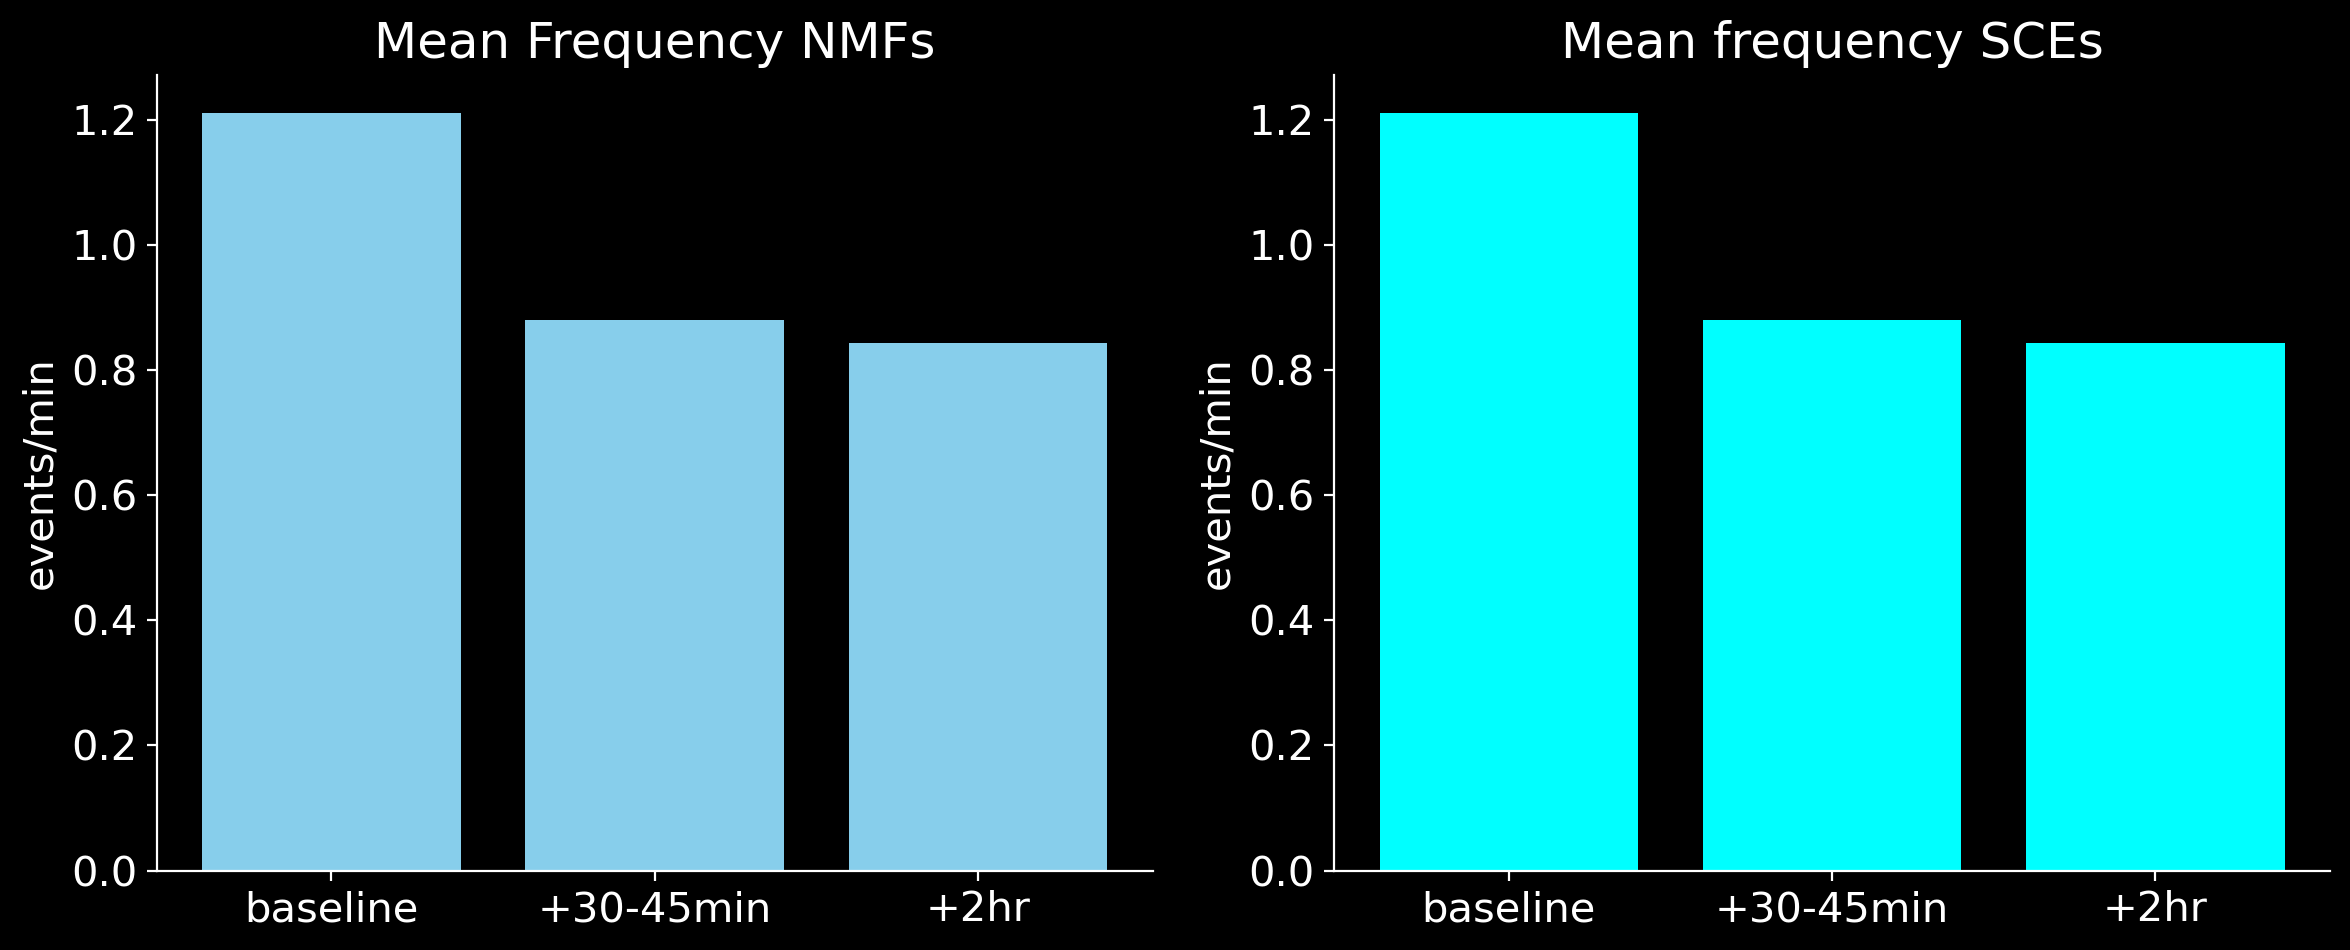

In [17]:
# Prepare lists to hold means per group
labels = list(all_pixel_nmf_fluox.keys())
mean_freqs_nmfs = []
mean_freqs_sces = []

# Compute means per group
for group in labels:
    group_data = all_pixel_nmf_fluox[group]
    # Extract lists of the metric values
    freqs_all_patterns_per_min = [d['mean_frequency_all_patterns_per_min'] for d in group_data]
    freqs_sces_per_min = [d['mean_frequency_all_acts_per_min'] for d in group_data]
    # Compute means and append
    mean_freqs_nmfs.append(np.mean(freqs_all_patterns_per_min))
    mean_freqs_sces.append(np.mean(freqs_sces_per_min))

# Plot results
fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=200)

# Bar plot 1: Mean frequency all patterns
axs[0].bar(labels, mean_freqs_nmfs, color='skyblue')
axs[0].set_title("Mean Frequency NMFs")
axs[0].set_ylabel("events/min")

# Bar plot 2: Mean frequency all patterns per minute
axs[1].bar(labels, mean_freqs_nmfs, color='cyan')
axs[1].set_title("Mean frequency SCEs")
axs[1].set_ylabel("events/min")

plt.tight_layout()
plt.show()

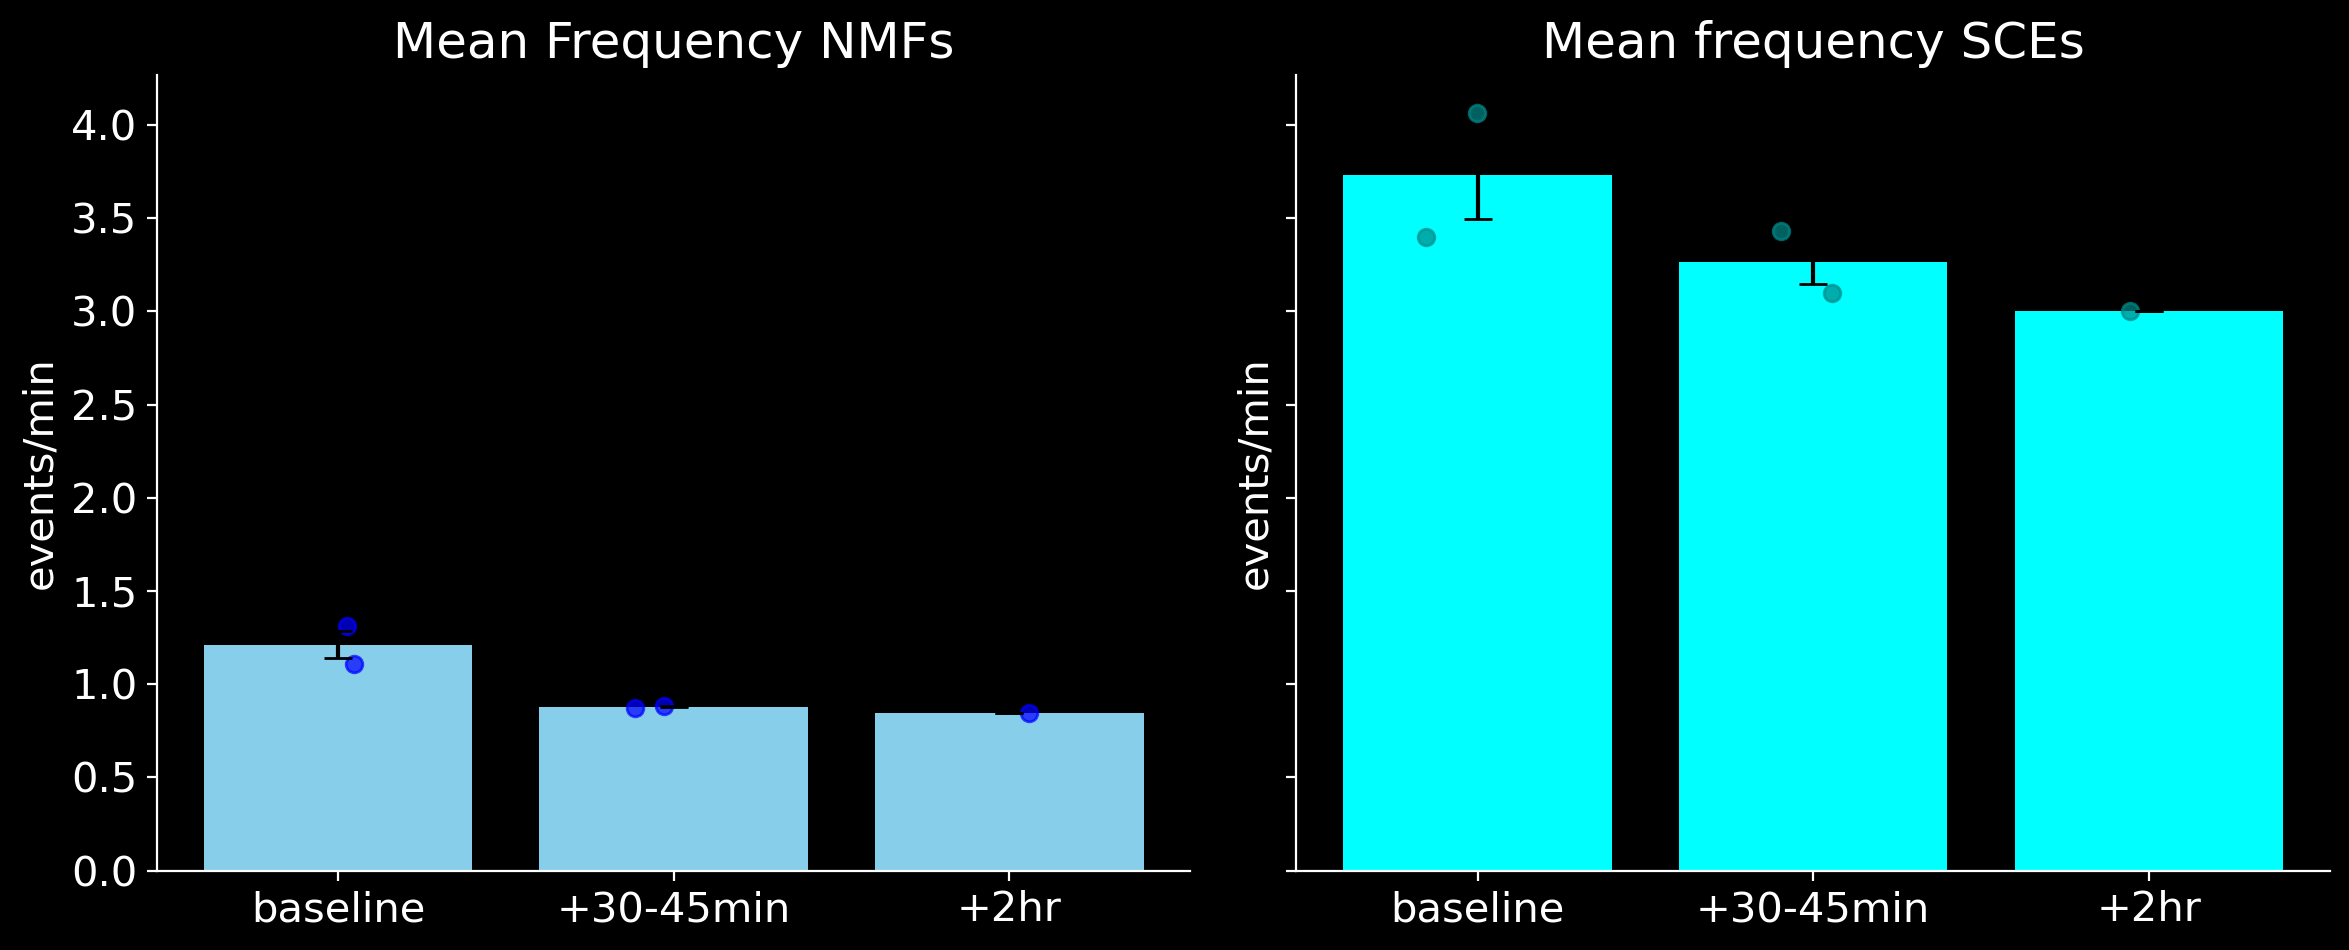

In [18]:
labels = list(all_pixel_nmf_fluox.keys())
mean_freqs_nmfs = []
mean_freqs_sces = []
std_freqs_nmfs = []
std_freqs_sces = []
raw_freqs_nmfs = []
raw_freqs_sces = []

# Compute means, stds and collect raw data per group
for group in labels:
    group_data = all_pixel_nmf_fluox[group]
    freqs_all_patterns_per_min = [d['mean_frequency_all_patterns_per_min'] for d in group_data]
    freqs_sces_per_min = [d['mean_frequency_all_acts_per_min'] for d in group_data]

    mean_freqs_nmfs.append(np.mean(freqs_all_patterns_per_min))
    mean_freqs_sces.append(np.mean(freqs_sces_per_min))
    std_freqs_nmfs.append(np.std(freqs_all_patterns_per_min) / np.sqrt(len(freqs_all_patterns_per_min)))  # SEM
    std_freqs_sces.append(np.std(freqs_sces_per_min) / np.sqrt(len(freqs_sces_per_min)))  # SEM

    raw_freqs_nmfs.append(freqs_all_patterns_per_min)
    raw_freqs_sces.append(freqs_sces_per_min)

fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=200, sharey=True)

# Bar plot 1: Mean frequency NMFs with error bars
bars1 = axs[0].bar(labels, mean_freqs_nmfs, color='skyblue', yerr=std_freqs_nmfs, capsize=5, error_kw=dict(color='grey'))
axs[0].set_title("Mean Frequency NMFs")
axs[0].set_ylabel("events/min")

# Scatter individual points for NMFs (jitter x for clarity)
for i, vals in enumerate(raw_freqs_nmfs):
    x = np.random.normal(i, 0.08, size=len(vals))
    axs[0].scatter(x, vals, color='blue', alpha=0.7)

# Bar plot 2: Mean frequency SCEs with error bars
bars2 = axs[1].bar(labels, mean_freqs_sces, color='cyan', yerr=std_freqs_sces, capsize=5, error_kw=dict(color='grey'))
axs[1].set_title("Mean frequency SCEs")
axs[1].set_ylabel("events/min")

# Scatter individual points for SCEs (jitter x for clarity)
for i, vals in enumerate(raw_freqs_sces):
    x = np.random.normal(i, 0.08, size=len(vals))
    axs[1].scatter(x, vals, color='darkcyan', alpha=0.7)

plt.tight_layout()
plt.show()

In [19]:
# Correlations within - without 

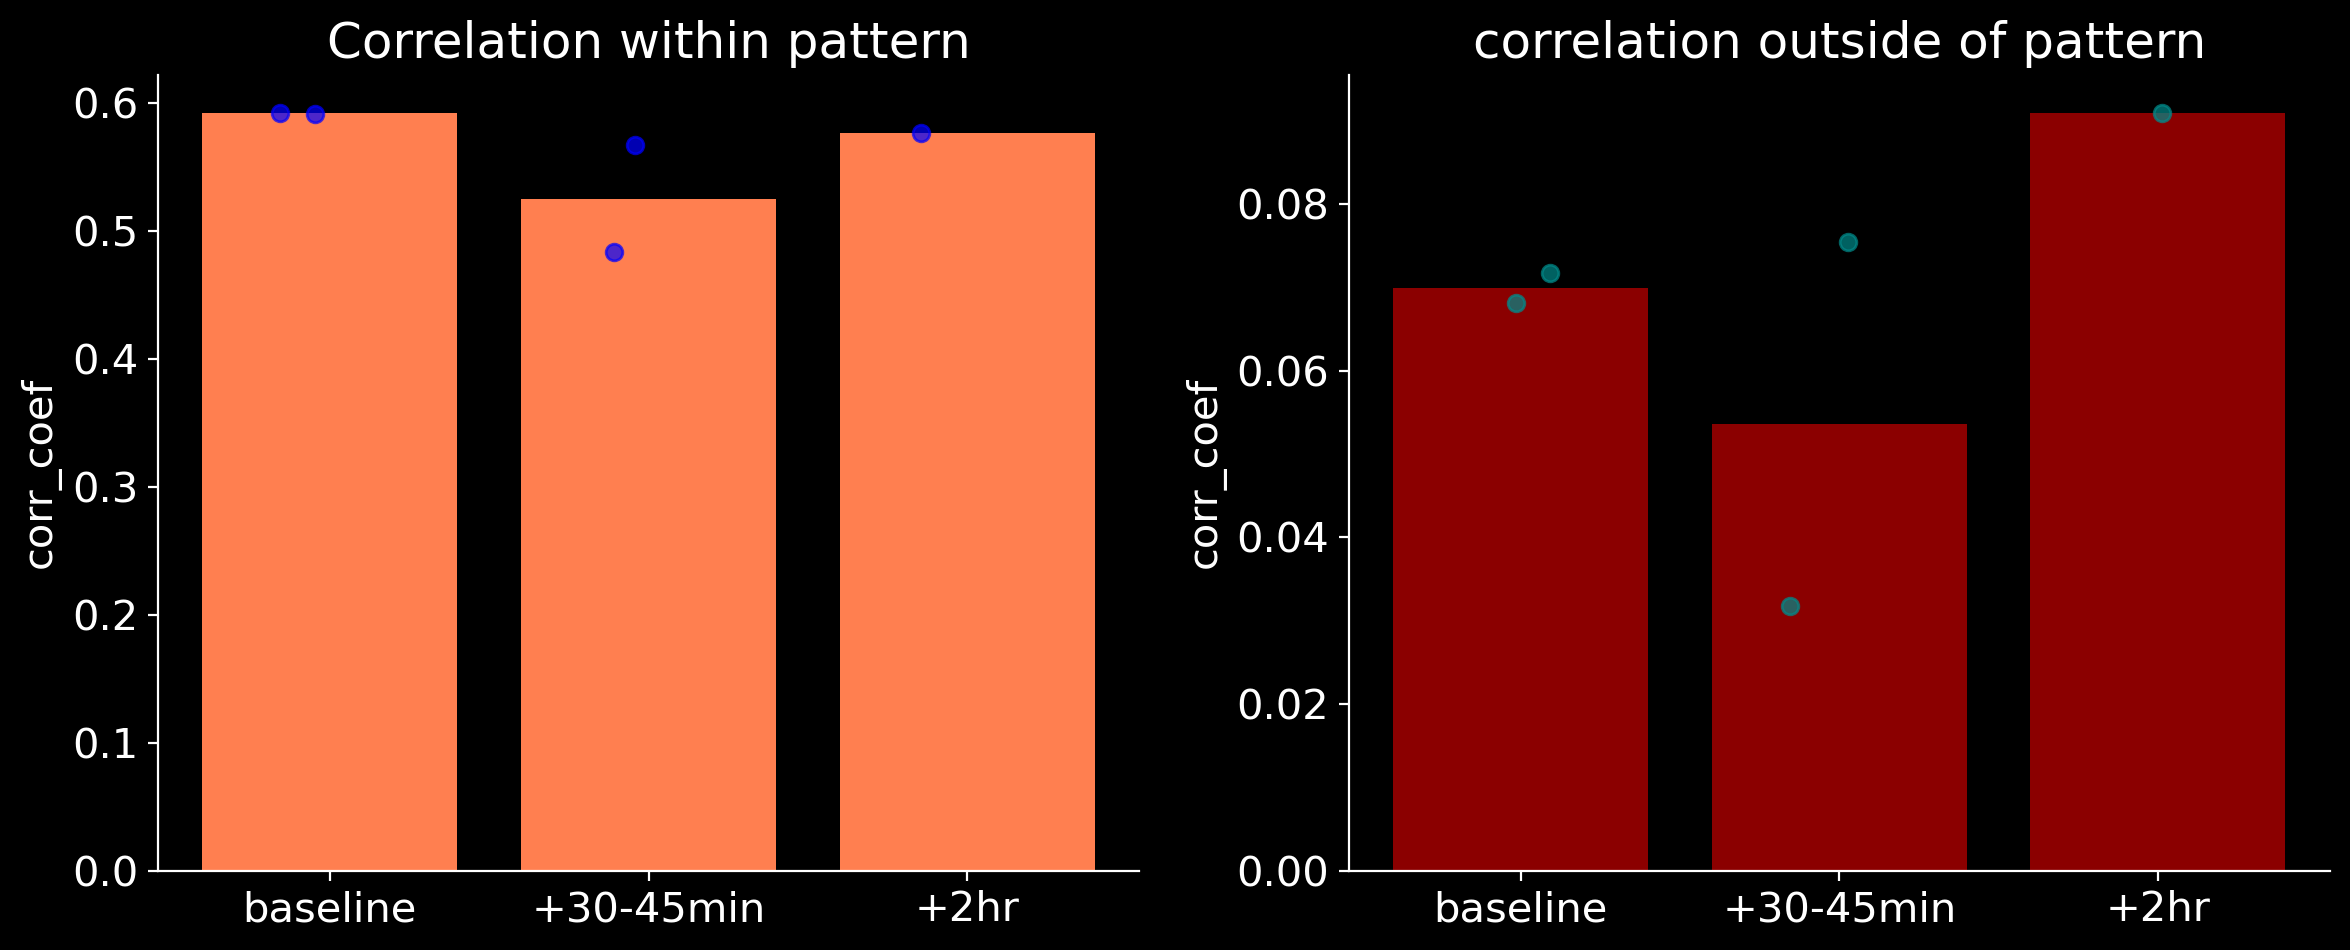

In [21]:
labels = list(all_pixel_nmf_fluox.keys())
mean_freqs_nmfs = []
mean_freqs_sces = []

# Collect raw data per group to scatter later
raw_freqs_nmfs = []
raw_freqs_sces = []

for group in labels:
    group_data = all_pixel_nmf_fluox[group]
    freqs_all_patterns_per_min = [d['mean_corrs_within_all_patterns'] for d in group_data]
    freqs_sces_per_min = [d['mean_corrs_in_out_all_patterns'] for d in group_data]
    
    mean_freqs_nmfs.append(np.mean(freqs_all_patterns_per_min))
    mean_freqs_sces.append(np.mean(freqs_sces_per_min))
    
    raw_freqs_nmfs.append(freqs_all_patterns_per_min)
    raw_freqs_sces.append(freqs_sces_per_min)

fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=200, sharey=False)

# Bar plot 1: Mean frequency NMFs
axs[0].bar(labels, mean_freqs_nmfs, color='coral')
axs[0].set_title("Correlation within pattern")
axs[0].set_ylabel("corr_coef")

# Scatter individual points for NMFs
for i, vals in enumerate(raw_freqs_nmfs):
    x = np.random.normal(i, 0.08, size=len(vals))  # jitter x for clarity
    axs[0].scatter(x, vals, color='blue', alpha=0.7)

# Bar plot 2: Mean frequency SCEs
axs[1].bar(labels, mean_freqs_sces, color='darkred')
axs[1].set_title("correlation outside of pattern")
axs[1].set_ylabel("corr_coef")

# Scatter individual points for SCEs
for i, vals in enumerate(raw_freqs_sces):
    x = np.random.normal(i, 0.08, size=len(vals))  # jitter x for clarity
    axs[1].scatter(x, vals, color='darkcyan', alpha=0.7)

plt.tight_layout()
plt.show()

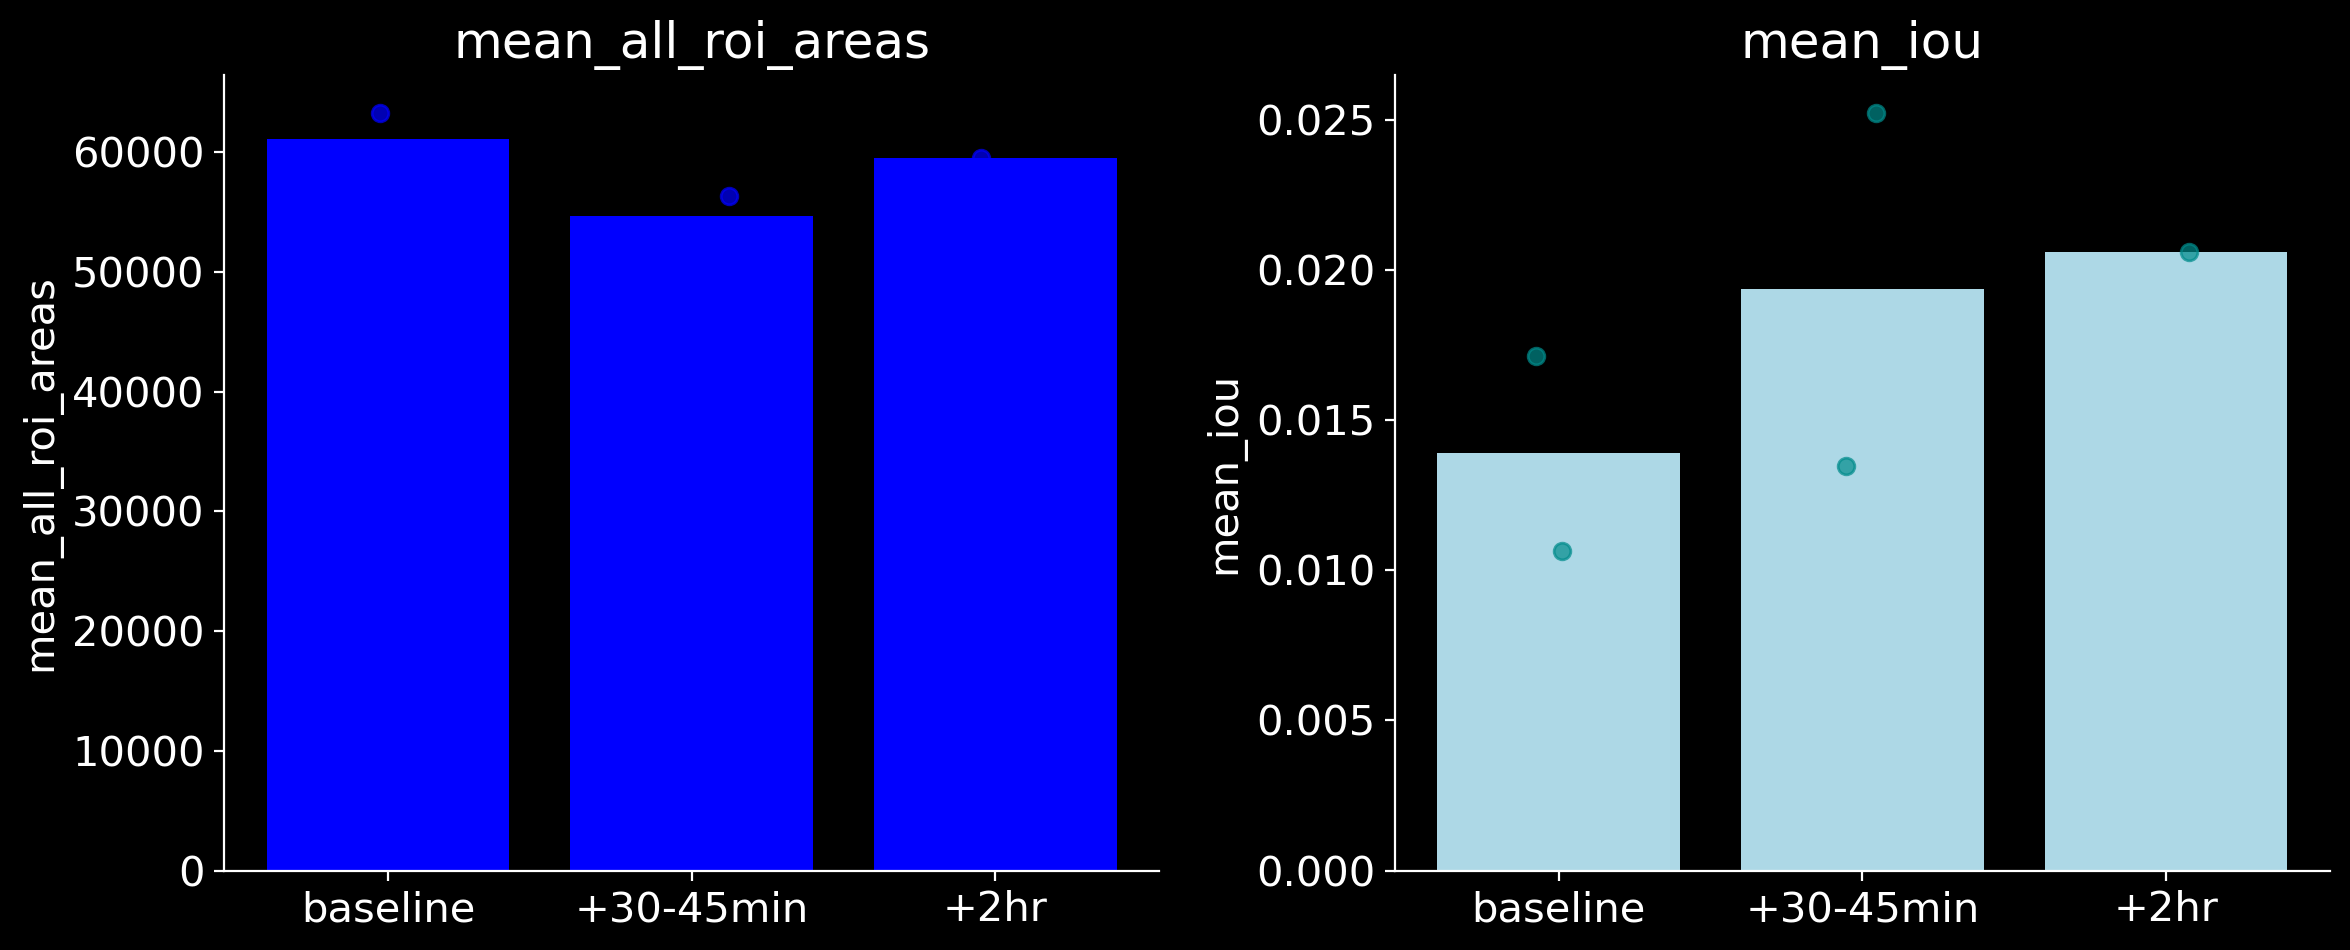

In [22]:
# area and iou

labels = list(all_pixel_nmf_fluox.keys())
mean_freqs_nmfs = []
mean_freqs_sces = []

# Collect raw data per group to scatter later
raw_freqs_nmfs = []
raw_freqs_sces = []

for group in labels:
    group_data = all_pixel_nmf_fluox[group]
    freqs_all_patterns_per_min = [d['mean_all_roi_areas'] for d in group_data]
    freqs_sces_per_min = [d['mean_iou'] for d in group_data]
    
    mean_freqs_nmfs.append(np.mean(freqs_all_patterns_per_min))
    mean_freqs_sces.append(np.mean(freqs_sces_per_min))
    
    raw_freqs_nmfs.append(freqs_all_patterns_per_min)
    raw_freqs_sces.append(freqs_sces_per_min)

fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=200, sharey=False)

# Bar plot 1: Mean frequency NMFs
axs[0].bar(labels, mean_freqs_nmfs, color='blue')
axs[0].set_title("mean_all_roi_areas")
axs[0].set_ylabel("mean_all_roi_areas")

# Scatter individual points for NMFs
for i, vals in enumerate(raw_freqs_nmfs):
    x = np.random.normal(i, 0.08, size=len(vals))  # jitter x for clarity
    axs[0].scatter(x, vals, color='blue', alpha=0.7)

# Bar plot 2: Mean frequency SCEs
axs[1].bar(labels, mean_freqs_sces, color='lightblue')
axs[1].set_title("mean_iou")
axs[1].set_ylabel("mean_iou")

# Scatter individual points for SCEs
for i, vals in enumerate(raw_freqs_sces):
    x = np.random.normal(i, 0.08, size=len(vals))  # jitter x for clarity
    axs[1].scatter(x, vals, color='darkcyan', alpha=0.7)

plt.tight_layout()
plt.show()

In [65]:
mean_freqs_per_min

array([1.10888889, 0.88444444, 0.84333333, 1.31428571, 0.8745098 ])

# Population coupling active population coupling rest 

In [28]:
# area and iou

labels = list(all_pixel_nmf_fluox.keys())
mean_freqs_nmfs = []
mean_freqs_sces = []

# Collect raw data per group to scatter later
raw_freqs_nmfs = []
raw_freqs_sces = []

for group in labels:
    group_data = all_pixel_nmf_fluox[group]
    freqs_all_patterns_per_min = [d['pop_coupling_local_sorted'] for d in group_data]
    freqs_sces_per_min = [d['pop_coupling_global_sorted'] for d in group_data]
    
    mean_freqs_nmfs.append(np.mean(freqs_all_patterns_per_min))
    mean_freqs_sces.append(np.mean(freqs_sces_per_min))
    
    raw_freqs_nmfs.append(freqs_all_patterns_per_min)
    raw_freqs_sces.append(freqs_sces_per_min)

fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=200, sharey=False)

# Bar plot 1: Mean frequency NMFs
axs[0].bar(labels, mean_freqs_nmfs, color='blue')
axs[0].set_title("pop_coupling_local_sorted")
axs[0].set_ylabel("pop_coupling_global_sorted")

# Scatter individual points for NMFs
for i, vals in enumerate(raw_freqs_nmfs):
    x = np.random.normal(i, 0.08, size=len(vals))  # jitter x for clarity
    axs[0].scatter(x, vals, color='blue', alpha=0.7)

# Bar plot 2: Mean frequency SCEs
axs[1].bar(labels, mean_freqs_sces, color='lightblue')
axs[1].set_title("mean_iou")
axs[1].set_ylabel("mean_iou")

# Scatter individual points for SCEs
for i, vals in enumerate(raw_freqs_sces):
    x = np.random.normal(i, 0.08, size=len(vals))  # jitter x for clarity
    axs[1].scatter(x, vals, color='darkcyan', alpha=0.7)

plt.tight_layout()
plt.show()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

# Behavior coupling 

In [32]:
import pandas as pd

In [49]:
violin_data = []

# Loop over each time group
for time_group, datasets in all_pixel_nmf_fluox.items():
    for ds in datasets:
        try:

            f1_data = ds['logistic_decoder_outputs_data_grid']['f1_both_classes']
            f1_pcs = ds['logistic_decoder_outputs_pcs']['f1_both_classes']
            # If you add NMFs later:
            # f1_nmfs = ds['logistic_decoder_outputs_nmfs']['f1_both_classes']

            violin_data.append({'Timepoint': time_group, 'Input Type': 'Data', 'F1 Score': f1_data})
            violin_data.append({'Timepoint': time_group, 'Input Type': 'PCs', 'F1 Score': f1_pcs})
            # violin_data.append({'Timepoint': time_group, 'Input Type': 'NMFs', 'F1 Score': f1_nmfs})
        except KeyError as e:
            print(f"❌ Missing key in dataset: {e}")

C:\Users\zaggila\AppData\Local\Temp\ipykernel_25872\1643946261.py:19: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.stripplot(


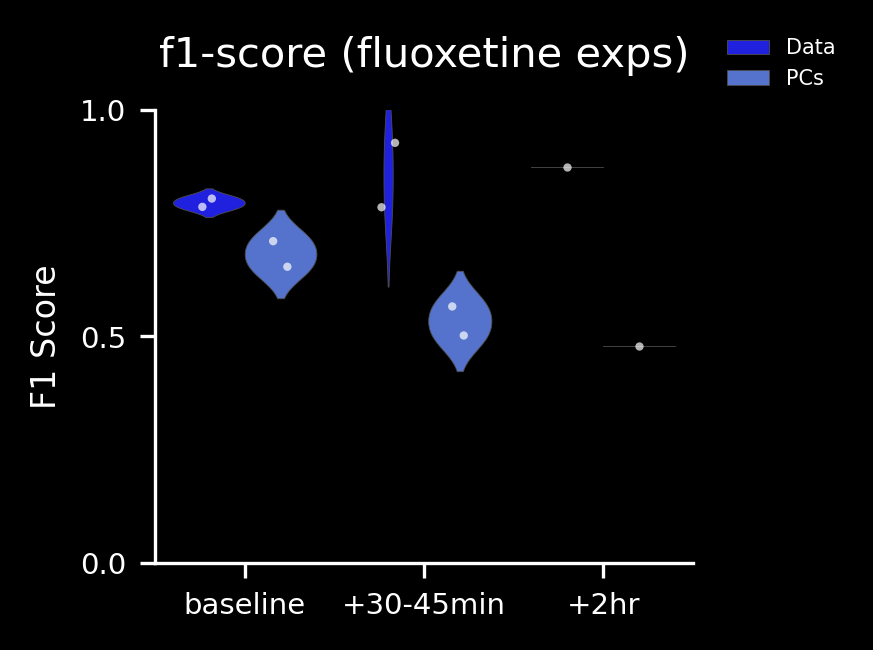

In [60]:
# Create violin_df as you have
violin_df = pd.DataFrame(violin_data)

# Plot
plt.figure(figsize=(3.5, 2.5), dpi=300)

# Violin plot
sns.violinplot(
    data=violin_df,
    x='Timepoint',
    y='F1 Score',
    hue='Input Type',
    palette=['blue', 'royalblue'],
    linewidth=0.2,
    inner=None  # turn off internal points, we'll plot them manually
)

# Overlay scatter (strip) points
sns.stripplot(
    data=violin_df,
    x='Timepoint',
    y='F1 Score',
    hue='Input Type',
    dodge=True,          # separate by hue
    palette=['white']*3, # use black for points (or match violin color)
    jitter=True,
    alpha=0.7,
    size=2
)

# Style
plt.xlabel('')
plt.ylabel('F1 Score', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title('f1-score (fluoxetine exps)', fontsize=10, pad=5, y=1.05)

# Avoid duplicate legends
handles, labels = plt.gca().get_legend_handles_labels()
n = len(set(violin_df['Input Type']))
plt.legend(handles[:n], labels[:n], title='', fontsize=5, loc='upper right', frameon=False, bbox_to_anchor=(1.3, 1.2))

plt.ylim(0, 1)
plt.tight_layout()
plt.show()

C:\Users\zaggila\AppData\Local\Temp\ipykernel_25872\1128260817.py:19: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.stripplot(


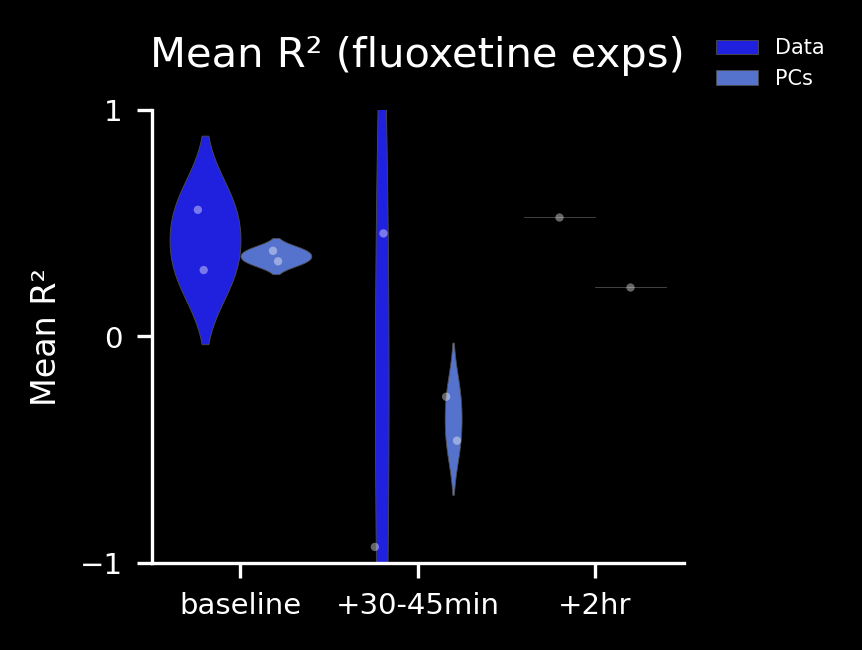

In [45]:
# Create violin_df as you have
violin_df = pd.DataFrame(violin_data)

# Plot
plt.figure(figsize=(3.5, 2.5), dpi=300)

# Violin plot
sns.violinplot(
    data=violin_df,
    x='Timepoint',
    y='Mean R²',
    hue='Input Type',
    palette=['blue', 'royalblue'],
    linewidth=0.2,
    inner=None  # turn off internal points, we'll plot them manually
)

# Overlay scatter (strip) points
sns.stripplot(
    data=violin_df,
    x='Timepoint',
    y='Mean R²',
    hue='Input Type',
    dodge=True,          # separate by hue
    palette=['white']*3, # use black for points (or match violin color)
    jitter=True,
    alpha=0.4,
    size=2
)

# Style
plt.xlabel('')
plt.ylabel('Mean R²', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title('Mean R² (fluoxetine exps)', fontsize=10, pad=5, y=1.05)

# Avoid duplicate legends
handles, labels = plt.gca().get_legend_handles_labels()
n = len(set(violin_df['Input Type']))
plt.legend(handles[:n], labels[:n], title='', fontsize=5, loc='upper right', frameon=False, bbox_to_anchor=(1.3, 1.2))

plt.ylim(-1, 1)
plt.tight_layout()
plt.show()

In [ ]:
# log reg 

In [ ]:
violin_data = []

# Loop over each time group
for time_group, datasets in all_pixel_nmf_fluox.items():
    for ds in datasets:
        try:
            # Extract mean R² for each input type
            mean_r2_data = ds['decoder_outputs_data']['mean_r2']
            mean_r2_pcs = ds['decoder_outputs_pcs']['mean_r2']
            # mean_r2_nmfs = ds['decoder_outputs_nmfs']['mean_r2']

            violin_data.append({'Timepoint': time_group, 'Input Type': 'Data', 'Mean R²': mean_r2_data})
            violin_data.append({'Timepoint': time_group, 'Input Type': 'PCs', 'Mean R²': mean_r2_pcs})
            # violin_data.append({'Timepoint': time_group, 'Input Type': 'NMFs', 'Mean R²': mean_r2_nmfs})
        except KeyError as e:
            print(f"❌ Missing key in dataset: {e}")

In [ ]:
# PCA dimensionality 

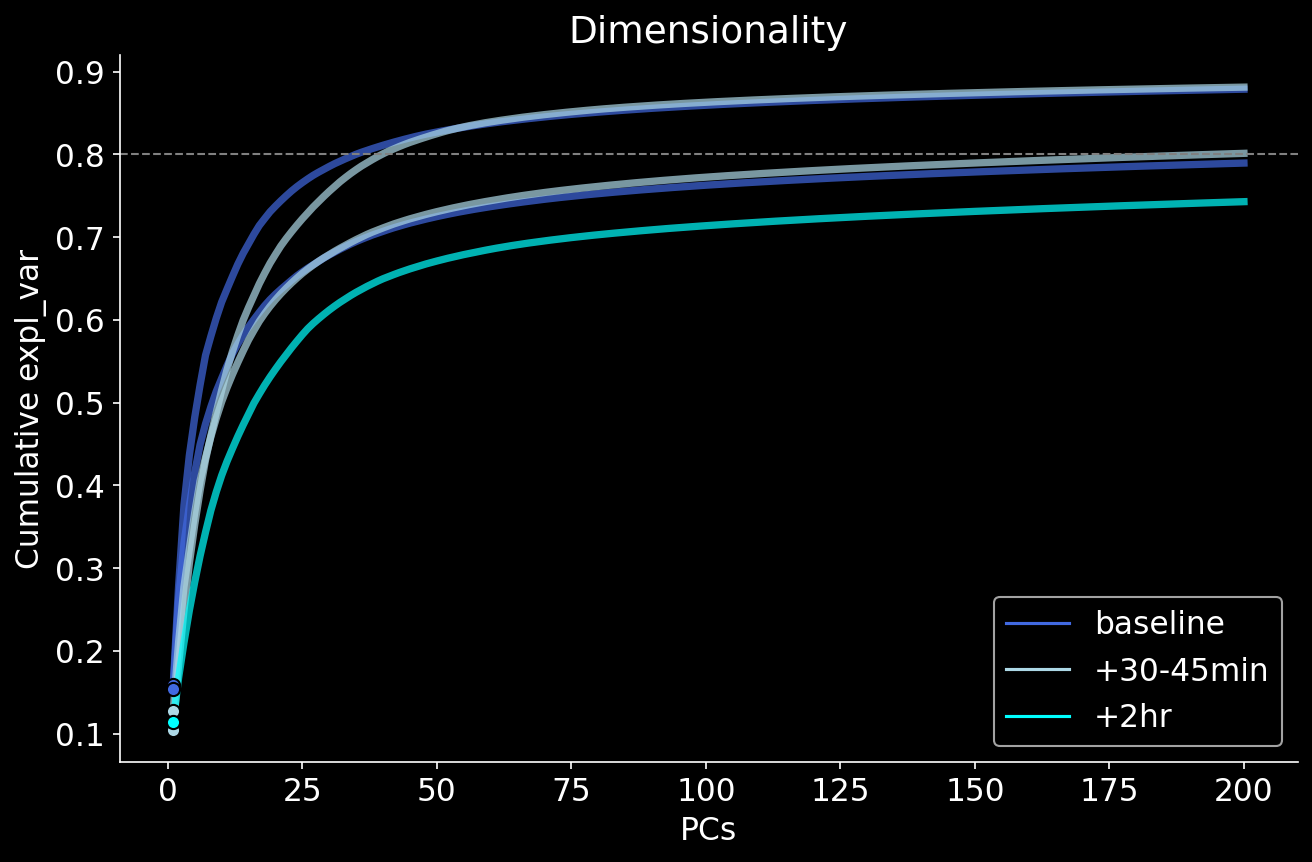

In [27]:
# Labels and their corresponding colors
labels = ['baseline', '+30-45min', '+2hr']
colors = ['royalblue', 'lightblue', 'cyan']

# Get the correct number of datasets in each group
group_sizes = [len(all_pixel_nmf_fluox[label]) for label in labels]  # [n1, n2, n3]
assert sum(group_sizes) == len(all_ds_fluox), "Mismatch in dataset count and group sizes"
# Number of datasets per group — adjust based on your data
group_indices = np.repeat(labels, group_sizes)
group_colors = np.repeat(colors, group_sizes)

# Extract cumulative explained variance for each dataset
cum_var_all = []
n_components_95 = []
max_len = 0

for ds in all_ds_fluox:
    var_exp = np.array(ds['var_exp_time'])  # per-frame PCA explained variance
    cum_var = np.cumsum(var_exp)
    cum_var_all.append(cum_var)
    max_len = max(max_len, len(cum_var))

    # Find number of components to explain 95%
    comp_95 = np.argmax(cum_var >= 0.95) + 1  # +1 for 1-based indexing
    n_components_95.append(comp_95)

# Pad cumulative arrays to the same length
cum_var_padded = [np.pad(v, (0, max_len - len(v)), mode='edge') for v in cum_var_all]

# Plot
plt.figure(figsize=(9, 6), dpi=150)

for i, cum_var in enumerate(cum_var_padded):
    group_color = group_colors[i]
    plt.plot(np.arange(1, max_len + 1), cum_var, color=group_color, alpha=0.7, linewidth=3.5)

    # Optionally, annotate where 95% is reached
    comp_95 = n_components_95[i]
    plt.scatter(comp_95, cum_var[comp_95 - 1], color=group_color, edgecolor='black', zorder=5, s=40)

# Plot horizontal 95% threshold
plt.axhline(0.8, color='grey', linestyle='--', linewidth=1)
# plt.text(1, 0.952, '95% variance', color='red')

# Legend
for label, color in zip(labels, colors):
    plt.plot([], [], color=color, label=label)

plt.xlabel("PCs")
plt.ylabel("Cumulative expl_var")
plt.title("Dimensionality")
plt.legend()
# plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

In [24]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Extract variables from your list of dicts
# mean_freqs_per_min = np.array([d['mean_frequency_all_patterns_per_min'] for d in all_ds_fluox])
# mean_acts_per_min = np.array([d['mean_frequency_all_acts_per_min'] for d in all_ds_fluox])
# mean_corrs_within = np.array([d['mean_corrs_within_all_patterns'] for d in all_ds_fluox])
# labels = ['baseline', '+45min', '+2hr']

# # Create 1x3 subplot
# fig, axs = plt.subplots(1, 3, figsize=(14, 4), sharey=False)

# # Bar plot 1: Frequency of all patterns
# axs[0].bar(labels, mean_freqs_per_min, color='skyblue')
# axs[0].set_title("All Patterns\n(Frequency per min)")
# axs[0].set_ylabel("Frequency per min")

# # Bar plot 2: Frequency of all acts
# axs[1].bar(labels, mean_acts_per_min, color='salmon')
# axs[1].set_title("All Acts\n(Frequency per min)")

# # Bar plot 3: Mean correlations within patterns
# axs[2].bar(labels, mean_corrs_within, color='mediumseagreen')
# axs[2].set_title("Within-Pattern\nMean Correlation")
# axs[2].set_ylabel("Mean Correlation")

# # Remove top and right spines
# for ax in axs:
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)

# plt.suptitle("Fluoxetine Effect on Patterns, Acts, and Correlation", fontsize=14)
# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.show()


In [23]:
# # # Bar plot for scalar mean frequencies
# # plt.figure(figsize=(6, 4))
# # plt.bar(labels, mean_freqs, color='skyblue')
# # plt.title("Mean Frequency of All Patterns")
# # plt.ylabel("Frequency")
# # plt.tight_layout()
# # plt.show()

# # Bar plot for per-minute frequencies
# plt.figure(figsize=(6, 4))
# plt.bar(labels, mean_freqs_per_min, color='salmon')
# plt.title("Mean Frequency of All Patterns (per min)")
# plt.ylabel("Frequency per min")
# plt.tight_layout()
# plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (3,) and arg 1 with shape (5,).

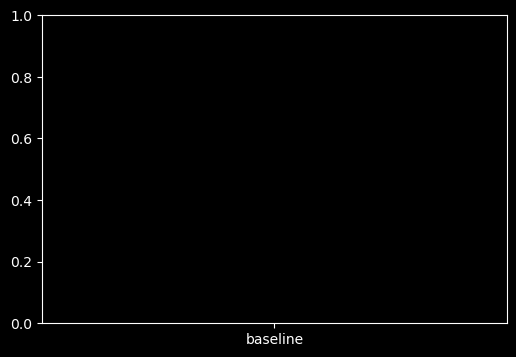

In [29]:
# all acts 

labels = ['baseline', '+45min', '+2hr']

# Extract values from each pixel_nmf dict
mean_frequency_all_acts_per_min = [d['mean_frequency_all_acts_per_min'] for d in all_ds_fluox]
mean_frequency_all_acts_per_min = np.array(mean_frequency_all_acts_per_min)

plt.figure(figsize=(6, 4))
plt.bar(labels, mean_frequency_all_acts_per_min, color='salmon')
plt.title("Mean Frequency of All Patterns (per min)")
plt.ylabel("Frequency per min")
plt.tight_layout()
plt.show()

In [ ]:
# Convert to NumPy arrays if not already
mean_freqs_per_min = np.array([d['mean_frequency_all_patterns_per_min'] for d in all_ds_fluox])
mean_acts_per_min = np.array([d['mean_frequency_all_acts_per_min'] for d in all_ds_fluox])
labels = ['baseline', '+45min', '+2hr']

# Create subplots: 1 row, 2 columns
fig, axs = plt.subplots(1, 2, figsize=(5, 4), sharey=False, dpi=300)

# First plot: all patterns
axs[0].bar(labels, mean_freqs_per_min, color='skyblue')
axs[0].set_title("pattern")
axs[0].set_ylabel("Hz")

# Second plot: all acts
axs[1].bar(labels, mean_acts_per_min, color='cyan')
axs[1].set_title("SCEs")

# Clean up spines (remove top and right)
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.suptitle("events/min", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('default')

def extract_data(dataset_list, key):
    """Helper to extract a list of arrays for a given key across dataset entries."""
    return [entry[key] for entry in dataset_list]

# Extract x and y polynomial fit values for each dataset
x_data_1 = extract_data(all_ds1, 'poly_fit_x_vals_iou')
y_data_1 = extract_data(all_ds1, 'poly_fit_y_vals_iou')

x_data_2 = extract_data(all_ds2, 'poly_fit_x_vals_iou')
y_data_2 = extract_data(all_ds2, 'poly_fit_y_vals_iou')

x_data_3 = extract_data(all_ds3, 'poly_fit_x_vals_iou')
y_data_3 = extract_data(all_ds3, 'poly_fit_y_vals_iou')

# Create a single subplot
fig, ax = plt.subplots(figsize=(7, 5), dpi=300, facecolor='black')
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

# Plot each dataset in different colors
for i in range(len(x_data_1)):
    ax.plot(x_data_1[i][1:7], y_data_1[i][:6], color='limegreen', label='emxp0p1' if i == 0 else '', linewidth=2)

for i in range(len(x_data_2)):
    ax.plot(x_data_2[i][1:7], y_data_2[i][:6], color='darkgreen', label='emxp2p4' if i == 0 else '', linewidth=2)

for i in range(len(x_data_3)):
    ax.plot(x_data_3[i][1:7], y_data_3[i][:6], color='indianred', label='gadp0p1' if i == 0 else '', linewidth=2)

# Labels and legend
ax.set_xlabel('Distance (μm)', color='white')
ax.set_ylabel('IoU', color='white', fontsize=15)
ax.legend(facecolor='black', edgecolor='white', fontsize=12, labelcolor='white', framealpha=0)

# Format plot aesthetics
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Save and show plot
plt.tight_layout()
# plt.savefig(f"{save_dir}/iou_vs_distance_three_datasets.png", facecolor='black')
plt.show()


In [ ]:
mean_frequency_all_acts_per_min

In [ ]:
mean_freqs_per_min

In [ ]:
mean_freqs

In [ ]:
print(pixel_nmf_a.keys())

In [ ]:
all_ds1[0].keys()
all_ds1[0]['mean_width_all_patterns']

In [ ]:
# all_ds4[7].keys()

In [ ]:
all_ds3[0]['mean_iou']

In [ ]:
all_ds4[5]['mean_iou']

In [ ]:
# plt.hist(all_ds3[1]['all_roi_areas'], bins = 50)

In [ ]:
# plt.hist(np.concatenate(all_ds3[1]['all_roi_areas']))
# plt.title('sz15 p1 gaba')
# plt.xlabel('area')

In [ ]:
# plt.hist(np.concatenate(all_ds3[4]['all_roi_areas']))
# plt.title('sz14 p1 gaba')
# plt.xlabel('area')

In [ ]:
all_ds4[3].keys()
all_ds4[4].keys()
all_ds4[5].keys()
all_ds4[1].keys()

# Areas 

## ds1 vs ds2 (emx young vs emx old)

In [ ]:
# all_data = np.concatenate([
#     all_ds1[0]['all_roi_areas'],
#     all_ds1[1]['all_roi_areas'],
#     all_ds1[2]['all_roi_areas'],
#     all_ds2[0]['all_roi_areas'],
#     all_ds2[1]['all_roi_areas'],
#     all_ds2[2]['all_roi_areas'],
#     all_ds2[3]['all_roi_areas'],
#     all_ds2[4]['all_roi_areas']
    
# ])

# # Determine the bin edges
# bins = np.linspace(np.min(all_data), np.max(all_data), 70) 

# # Create the histogram plot
# plt.figure(figsize=(10, 6))

# # Plot each histogram with Seaborn
# sns.histplot(all_ds1[0]['all_roi_areas'], bins=bins, color='lightblue', kde=False, label = 'emx p0-p1 (n=2)')
# sns.histplot(all_ds1[1]['all_roi_areas'], bins=bins, color='lightblue', kde=False)
# sns.histplot(all_ds1[1]['all_roi_areas'], bins=bins, color='lightblue', kde=False)


# sns.histplot(all_ds2[0]['all_roi_areas'], bins=bins, color='blue', kde=False, label= 'emx p2-p4 (n=4)')
# sns.histplot(all_ds2[1]['all_roi_areas'], bins=bins, color='blue', kde=False)
# sns.histplot(all_ds2[2]['all_roi_areas'], bins=bins, color='blue', kde=False)
# sns.histplot(all_ds2[3]['all_roi_areas'], bins=bins, color='blue', kde=False)
# sns.histplot(all_ds2[4]['all_roi_areas'], bins=bins, color='blue', kde=False)


# # Add labels and title
# plt.xlabel('area (10*6 μm**2)')
# plt.ylabel('Count')
# plt.title('Pattern area')

# plt.legend()
# plt.show()


# # Extract data from each dataset
# data1_1 = all_ds1[0]['all_roi_areas']
# data1_2 = all_ds1[1]['all_roi_areas']
# data1_3 = all_ds1[2]['all_roi_areas']

# data1_area = data1_1 + data1_2 + data1_3
# data1_area = flatten_and_scale(data1_area)


# data2_1 = all_ds2[0]['all_roi_areas']
# data2_2 = all_ds2[1]['all_roi_areas']
# data2_3 = all_ds2[2]['all_roi_areas']
# data2_4 = all_ds2[3]['all_roi_areas']
# data2_5 = all_ds2[4]['all_roi_areas']

# data2_area = data2_1 + data2_2 + data2_3 + data2_4 + data2_5
# data2_area = flatten_and_scale(data2_area)

# # Combine all data into a list
# data12_area = [data1_area, data2_area]

# # Create the violin plot
# plt.figure(figsize=(8, 6))
# parts = plt.violinplot(data12_area, showmeans=True, showmedians=True)

# # Overlay individual data points
# for i, d in enumerate(data12_area):
#     y = np.random.normal(i + 1, 0.05, size=len(d))
#     plt.scatter(y, d, color='black', alpha=0.6)

# # Customizing colors for each violin
# colors = ['lightblue', 'blue']
# for pc, color in zip(parts['bodies'], colors):
#     pc.set_facecolor(color)
#     pc.set_edgecolor('black')
#     pc.set_alpha(0.7)

# for line in ['cmedians', 'cmeans', 'cbars', 'cmaxes', 'cmins']:
#     if line in parts:
#         parts[line].set_edgecolor('grey')
#         parts[line].set_alpha(0.7)


# # Set the x-tick labels
# plt.xticks([1, 2], ['emx p0-p1', ' emx p2-p4'])


# # Add labels and title
# plt.ylabel(' areas (10*2) μm**2)', fontsize=20)
# plt.title('pattern areas', fontisize=25)

# # Show plot
# plt.show()

In [ ]:
all_ds3[1]['all_roi_areas']
all_ds3[2]['all_roi_areas']

In [ ]:
# all_ds1_areas_scaled
# all_ds2_areas_scaled

In [ ]:
flatten_and_scale

In [ ]:
# from matplotlib.ticker import FuncFormatter

# # Scale and convert data to integers
# all_ds1_areas_scaled = scale_data([ds['all_roi_areas'] for ds in all_ds1])
# all_ds2_areas_scaled = scale_data([ds['all_roi_areas'] for ds in all_ds2])

# bins = np.linspace(np.min([np.min(data) for data in all_ds1_areas_scaled + all_ds2_areas_scaled]), np.max([np.max(data) for data in all_ds1_areas_scaled + all_ds2_areas_scaled]), 70)

# fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=200)

# sns.histplot(all_ds1_areas_scaled[0], bins=bins, color='lightblue', kde=False, label='emx p0-p1 (n=2)', ax=axs[0])  #here is areas_scaled the dict ? no 
# sns.histplot(all_ds1_areas_scaled[1], bins=bins, color='lightblue', kde=False, ax=axs[0])
# sns.histplot(all_ds1_areas_scaled[2], bins=bins, color='lightblue', kde=False, ax=axs[0])

# sns.histplot(all_ds2_areas_scaled[0], bins=bins, color='blue', kde=False, label='emx p2-p4 (n=4)', ax=axs[0])
# sns.histplot(all_ds2_areas_scaled[1], bins=bins, color='blue', kde=False, ax=axs[0])
# sns.histplot(all_ds2_areas_scaled[2], bins=bins, color='blue', kde=False, ax=axs[0])
# sns.histplot(all_ds2_areas_scaled[3], bins=bins, color='blue', kde=False, ax=axs[0])
# sns.histplot(all_ds2_areas_scaled[4], bins=bins, color='blue', kde=False, ax=axs[0])

# # Add labels and title to the first subplot
# axs[0].set_xlabel('area (*10**2) (μm**2)', fontsize=15)
# axs[0].set_ylabel('Count', fontsize=15)
# axs[0].set_title('pattern Area', fontsize=20)
# axs[0].legend()

# #ALREADY SCALED BEFORE
# data12_area = [data1_area, data2_area]

# parts = axs[1].violinplot(data12_area, showmeans=True, showmedians=True)

# # Overlay individual data points
# for i, d in enumerate(data12_area):
#     y = np.random.normal(i + 1, 0.05, size=len(d))
#     axs[1].scatter(y, d, color='black', alpha=0.6)

# # Customizing colors for each violin
# colors = ['lightblue', 'blue']
# for pc, color in zip(parts['bodies'], colors):
#     pc.set_facecolor(color)
#     pc.set_edgecolor('black')
#     pc.set_alpha(0.7)

# for line in ['cmedians', 'cmeans', 'cbars', 'cmaxes', 'cmins']:
#     if line in parts:
#         parts[line].set_edgecolor('grey')
#         parts[line].set_alpha(0.7)

# # Set the x-tick labels for the violin plot
# axs[1].set_xticks([1, 2])
# axs[1].set_xticklabels(['emx p0-p1', 'emx p2-p4'], fontsize=15)

# # Add labels and title to the second subplot
# axs[1].set_ylabel('area (*10**2) (μm**2)', fontsize=15)
# axs[1].set_title('pattern area', fontsize=20)

# # Adjust layout
# plt.tight_layout()

# #plt.savefig(save_dir + '/patch_area_ds1_ds2.png', bbox_inches="tight")

# # Show plot
# plt.show()

In [ ]:
# from matplotlib.ticker import FuncFormatter

# # Scale and convert data to integers
# all_ds1_areas_scaled = scale_data([ds['all_roi_areas'] for ds in all_ds1])
# all_ds2_areas_scaled = scale_data([ds['all_roi_areas'] for ds in all_ds2])

# bins = np.linspace(np.min([np.min(data) for data in all_ds1_areas_scaled + all_ds2_areas_scaled]), np.max([np.max(data) for data in all_ds1_areas_scaled + all_ds2_areas_scaled]), 70)

# fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=200)

# sns.histplot(all_ds1_areas_scaled[0], bins=bins, color='lightblue', kde=False, label='emx p0-p1 (n=2)', ax=axs[0])  #here is areas_scaled the dict ? no 
# sns.histplot(all_ds1_areas_scaled[1], bins=bins, color='lightblue', kde=False, ax=axs[0])
# sns.histplot(all_ds1_areas_scaled[2], bins=bins, color='lightblue', kde=False, ax=axs[0])

# sns.histplot(all_ds2_areas_scaled[0], bins=bins, color='blue', kde=False, label='emx p2-p4 (n=4)', ax=axs[0])
# sns.histplot(all_ds2_areas_scaled[1], bins=bins, color='blue', kde=False, ax=axs[0])
# sns.histplot(all_ds2_areas_scaled[2], bins=bins, color='blue', kde=False, ax=axs[0])
# sns.histplot(all_ds2_areas_scaled[3], bins=bins, color='blue', kde=False, ax=axs[0])
# sns.histplot(all_ds2_areas_scaled[4], bins=bins, color='blue', kde=False, ax=axs[0])

# # Add labels and title to the first subplot
# axs[0].set_xlabel('area (*10**2) (μm**2)', fontsize=15)
# axs[0].set_ylabel('Count', fontsize=15)
# axs[0].set_title('pattern Area', fontsize=20)
# axs[0].legend()

# #ALREADY SCALED BEFORE
# data12_area = [data1_area, data2_area]

# parts = axs[1].violinplot(data12_area, showmeans=True, showmedians=True)

# # Overlay individual data points
# for i, d in enumerate(data12_area):
#     y = np.random.normal(i + 1, 0.05, size=len(d))
#     axs[1].scatter(y, d, color='black', alpha=0.6)

# # Customizing colors for each violin
# colors = ['lightblue', 'blue']
# for pc, color in zip(parts['bodies'], colors):
#     pc.set_facecolor(color)
#     pc.set_edgecolor('black')
#     pc.set_alpha(0.7)

# for line in ['cmedians', 'cmeans', 'cbars', 'cmaxes', 'cmins']:
#     if line in parts:
#         parts[line].set_edgecolor('grey')
#         parts[line].set_alpha(0.7)

# # Set the x-tick labels for the violin plot
# axs[1].set_xticks([1, 2])
# axs[1].set_xticklabels(['emx p0-p1', 'emx p2-p4'], fontsize=15)

# # Add labels and title to the second subplot
# axs[1].set_ylabel('area (*10**2) (μm**2)', fontsize=15)
# axs[1].set_title('pattern area', fontsize=20)

# # Adjust layout
# plt.tight_layout()

# #plt.savefig(save_dir + '/patch_area_ds1_ds2.png', bbox_inches="tight")

# # Show plot
# plt.show()

## try to plot all data 

In [ ]:
len(all_ds1)

In [ ]:
# len(all_ds2)
# all_ds2[0]['non_border_roi_areas']

In [ ]:
all_ds1[0]['non_border_roi_areas']

In [ ]:
def extract_data(data_dict, variable_name):
    collected_data_for_variable = []
    try:
        for i, ds in enumerate(data_dict):
            collected_data_for_variable.append(ds[variable_name])
    except KeyError:
        print(f'Ds {i} does not contain variable {variable_name}')
    return collected_data_for_variable

# MEAN SIZE PER DS IN LOG SCALE ### ADD N 
1. NON BORDER == mean_areas_borders_out
2. BORDER == all_roi_areas GET MEAN BEFORE PLOTTING

4. NON BORDER FOR GLUT BORDER IN FOR GABA BECS RARE

In [ ]:
# y1 = np.log(y1)

In [ ]:
# y1 = extract_data(all_ds1, 'non_border_roi_areas')
# y1

In [ ]:
flatten?

In [ ]:
flatten_and_scale?

In [ ]:
y1 = np.sqrt(flatten(extract_data(all_ds1, 'mean_areas_borders_out')))
y2 = np.sqrt(flatten(extract_data(all_ds2, 'mean_areas_borders_out')))
y3 = np.sqrt(flatten(extract_data(all_ds3, 'mean_areas_borders_out')))
y4 = np.sqrt(flatten(extract_data(all_ds4, 'mean_areas_borders_out')))

# y1= y1/100
# y2= y2/100
# y3= y3/100
# y4= y4/100
# y1 = np.log(y1)
# y2 = np.log(y2)
# y3 = np.log(y3)
# y4 = np.log(y4)

mean_y1, std_y1 = np.mean(y1), np.std(y1)
mean_y2, std_y2 = np.mean(y2), np.std(y2)
mean_y3, std_y3 = np.mean(y3), np.std(y3)
mean_y4, std_y4 = np.mean(y4), np.std(y4)

# plt.style.use('dark_background')

plt.figure(figsize=(3,3), dpi=300)


v1 = plt.violinplot(y1, [1], showmeans=True)
v2 = plt.violinplot(y2, [2], showmeans=True)
v3 = plt.violinplot(y3, [3], showmeans=True)
v4 = plt.violinplot(y4, [4], showmeans=True)

# Set colors for the violins
colors = ['lightgreen', 'green', 'lightcoral', 'red']
violins = [v1,v2,v3,v4]

for v, color in zip(violins, colors):
    for pc in v['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)

# Plot individual data points with scatter
plt.title('Pattern Area', fontsize=15)

plt.scatter(np.full(len(y1), 1), y1, color='grey', alpha=0.7)
plt.scatter(np.full(len(y2), 2), y2, color='grey', alpha=0.7)
plt.scatter(np.full(len(y3), 3), y3, color='grey', alpha=0.7)
plt.scatter(np.full(len(y4), 4), y4, color='grey', alpha=0.7)

# Plot means and standard deviations as text on the plot
# plt.text(1, mean_y1 + std_y1, f"mean: {mean_y1:.2f}\nsd: {std_y1:.2f}", ha='center', fontsize=7)
# plt.text(2, mean_y2 + std_y2, f"mean: {mean_y2:.2f}\nsd: {std_y2:.2f}", ha='center', fontsize=7)
# plt.text(3, mean_y3 + std_y3, f"mean: {mean_y3:.2f}\nsd: {std_y3:.2f}", ha='center', fontsize=7)
# plt.text(4, mean_y4 + std_y4, f"mean: {mean_y4:.2f}\nsd: {std_y4:.2f}", ha='center', fontsize=7)

plt.ylim(0, max(np.max(y1), np.max(y2), np.max(y3), np.max(y4)) * 1.1)

plt.xticks([1, 2, 3, 4], ["Glut_p0p1", "Glut_p2p4", "GABA_p0p1", "GABA_p2p4"], fontsize=35)

plt.ylabel('Area² (µm²)')

plt.xticks(fontsize=5)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(save_dir + 'areas.png')

In [ ]:
import seaborn as sns

# Create the figure
plt.figure(figsize=(10, 6), dpi=300)

# Plot KDEs for each dataset
sns.kdeplot(y1, color='lightgreen', fill=True, alpha=0.6, label='Glut_p0p1', linewidth=2)
sns.kdeplot(y2, color='green', fill=True, alpha=0.6, label='Glut_p2p4', linewidth=2)
sns.kdeplot(y3, color='lightcoral', fill=True, alpha=0.6, label='GABA_p0p1', linewidth=2)
sns.kdeplot(y4, color='red', fill=True, alpha=0.6, label='GABA_p2p4', linewidth=2)


# Set x-ticks with labels

# Set y-label
plt.ylabel('Density', fontsize=25)
plt.xlabel('sqrt(Area) (µm²)', fontsize=25)
plt.xticks(fontsize=15)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')

plt.legend(fontsize=20)

# Add title
plt.title('Pattern Area', fontsize=30, color='white')

# Show the plot
plt.tight_layout()

plt.savefig(save_dir + 'areas_density.png')
plt.show()

## Checking normality

In [ ]:
from scipy.stats import shapiro

ds = [y1, y2, y3, y4]
for idx, dataset in enumerate(ds, start=1):
# Perform the Shapiro-Wilk test for normality
    stat, p = shapiro(dataset)
    print(f"Shapiro-Wilk Test for {idx}: Statistics={stat}, p-value={p}")

## Checking equality of variances 

In [ ]:
from scipy.stats import levene

stat, p = levene(y1, y2, y3, y4)
print(f"Levene’s Test: Statistics={stat}, p-value={p}")

## Checking for any stat different ds distribution

In [ ]:
from scipy.stats import kruskal

stat, p = kruskal(y1, y2, y3, y4)
print(f"Kruskal-Wallis Test: Statistics={stat}, p-value={p}")

In [ ]:
from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu(y1,y2)
print(f"Mann-Whitney U Test between y1 and y2: Statistics={stat}, p-value={p}")

In [ ]:
stat, p = mannwhitneyu(y1,y3)
print(f"Mann-Whitney U Test between y1 and y3: Statistics={stat}, p-value={p}")

In [ ]:
stat, p = mannwhitneyu(y3,y4)
print(f"Mann-Whitney U Test between y3 and y4: Statistics={stat}, p-value={p}")

In [ ]:
stat, p = mannwhitneyu(y2,y3)
print(f"Mann-Whitney U Test between y1 and y3: Statistics={stat}, p-value={p}")

In [ ]:
stat, p = mannwhitneyu(y2,y4)
print(f"Mann-Whitney U Test between y2 and y4: Statistics={stat}, p-value={p}")

## ALL roi areas including edge cases 

In [ ]:
y1 = np.sqrt(flatten(extract_data(all_ds1, 'mean_all_roi_areas')))
y2 = np.sqrt(flatten(extract_data(all_ds2, 'mean_all_roi_areas')))
y3 = np.sqrt(flatten(extract_data(all_ds3, 'mean_all_roi_areas')))
y4 = np.sqrt(flatten(extract_data(all_ds4, 'mean_all_roi_areas')))

# y1 = np.log(y1)
# y2 = np.log(y2)
# y3 = np.log(y3)
# y4 = np.log(y4)

mean_y1, std_y1 = np.mean(y1), np.std(y1)
mean_y2, std_y2 = np.mean(y2), np.std(y2)
mean_y3, std_y3 = np.mean(y3), np.std(y3)
mean_y4, std_y4 = np.mean(y4), np.std(y4)

plt.style.use('dark_background')

plt.figure(figsize=(4,5), dpi=200)
plt.title('Pattern Area', fontsize=20)

v1 = plt.violinplot(y1, [1], showmeans=True)
v2 = plt.violinplot(y2, [2], showmeans=True)
v3 = plt.violinplot(y3, [3], showmeans=True)
v4 = plt.violinplot(y4, [4], showmeans=True)

# Set colors for the violins
colors = ['lightgreen', 'green', 'lightcoral', 'red']
violins = [v1,v2,v3,v4]

for v, color in zip(violins, colors):
    for pc in v['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)

# Plot individual data points with scatter
plt.scatter(np.full(len(y1), 1), y1, color='grey', alpha=0.5)
plt.scatter(np.full(len(y2), 2), y2, color='grey', alpha=0.5)
plt.scatter(np.full(len(y3), 3), y3, color='grey', alpha=0.5)
plt.scatter(np.full(len(y4), 4), y4, color='grey', alpha=0.5)

# # Plot means and standard deviations as text on the plot
# plt.text(1, mean_y1 + std_y1, f"Mean: {mean_y1:.2f}\nSD: {std_y1:.2f}", ha='center', fontsize=7)
# plt.text(2, mean_y2 + std_y2, f"Mean: {mean_y2:.2f}\nSD: {std_y2:.2f}", ha='center', fontsize=7)
# plt.text(3, mean_y3 + std_y3, f"Mean: {mean_y3:.2f}\nSD: {std_y3:.2f}", ha='center', fontsize=7)
# plt.text(4, mean_y4 + std_y4, f"Mean: {mean_y4:.2f}\nSD: {std_y4:.2f}", ha='center', fontsize=7)

plt.xticks([1, 2, 3, 4], ["Glut_p0p1", "Glut_p2p4", "GABA_p0p1", "GABA_p2p4"])


plt.ylim(0, max(np.max(y1), np.max(y2), np.max(y3), np.max(y4)) * 1.1)


plt.ylabel('Area (µm²)', fontsize=15)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [ ]:

import seaborn as sns

# Create the figure
plt.figure(figsize=(15, 10), dpi=200)

# Plot KDEs for each dataset
sns.kdeplot(y1, color='lightgreen', fill=True, alpha=0.6, label='emx_p0p1', linewidth=2)
sns.kdeplot(y3, color='indianred', fill=True, alpha=0.6, label='gad_p0p1', linewidth=2)

# Set y-label
plt.ylabel('Density', fontsize=12)

# Customize grid and spine visibility
plt.grid(axis='y', color='grey', linestyle='--', alpha=0.5)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')

# Add title
plt.title('Pattern Area', fontsize=15, color='white')

# Show the plot
plt.tight_layout()
plt.show()

## All areas included (edge cases too)

In [ ]:
plt.figure(figsize=(10, 6), dpi=300)

sns.kdeplot(y1, color='lightgreen', fill=True, alpha=0.6, label='emx_p0p1', linewidth=2)
sns.kdeplot(y2, color='green', fill=True, alpha=0.6, label='emx_p2p4', linewidth=2)
sns.kdeplot(y3, color='lightcoral', fill=True, alpha=0.6, label='gad_p0p1', linewidth=2)
sns.kdeplot(y4, color='red', fill=True, alpha=0.6, label='gad_p2p4', linewidth=2)


plt.ylabel('Density', fontsize=20)
plt.xlabel('Area (µm²)')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')

plt.legend()

# Add title
plt.title('Pattern Area', fontsize=25, color='white')

# Show the plot
plt.tight_layout()
plt.show()

## IoUs 

== mean_iou

In [ ]:
# def flatten(data):
#     if isinstance(data,list):
#         return [item for sublist in data for item in sublist] 
    
#     else:
#         return [data]
    
y1 = flatten(extract_data(all_ds1, 'ious_filt_mean'))
y2 = flatten(extract_data(all_ds2, 'ious_filt_mean'))
y3 = flatten(extract_data(all_ds3, 'ious_filt_mean'))
y4 = flatten(extract_data(all_ds4, 'ious_filt_mean'))

# # keep all values that are non 0 using list comprehension
y1 = [value*100 for value in y1]
y2 = [value*100 for value in y2]
y3 = [value*100 for value in y3]
y4 = [value*100 for value in y4]

In [ ]:
# Set the background color of the figure and axes to black
plt.figure(figsize=(4, 5), dpi=200, facecolor='black')
ax = plt.gca()
ax.set_facecolor('black')

# Violin plots
v1 = plt.violinplot(y1, [1], showmeans=True)
v2 = plt.violinplot(y2, [2], showmeans=True)
v3 = plt.violinplot(y3, [3], showmeans=True)
v4 = plt.violinplot(y4, [4], showmeans=True)

colors = ['lightgreen', 'green', 'lightcoral', 'red']
violins = [v1,v2,v3,v4]

for v, color in zip(violins, colors):
    for pc in v['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)

# Scatter plot of individual data points
plt.scatter(np.full(len(y1), 1), y1, color='grey', alpha=0.5, s=1)
plt.scatter(np.full(len(y2), 2), y2, color='grey', alpha=0.5, s=1)
plt.scatter(np.full(len(y3), 3), y3, color='grey', alpha=0.5, s=1)
plt.scatter(np.full(len(y4), 4), y4, color='grey', alpha=0.5, s=1)

# Title and labels in white
plt.title('Mean IoU', fontsize=20, color='white')
plt.ylabel('Overlap %', color='white')

# X-axis labels in white
plt.xticks([1, 2, 3, 4], ["Glut_p0p1", "Glut_p2p4", "GABA_p0p1", "GABA_p2p4"], color='white', fontsize=10)

# Adjust the axes ticks and spines for black background
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Make the remaining spines and labels white
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

plt.savefig(save_dir + 'ious.png')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6), dpi=300)

sns.kdeplot(y1, color='lightgreen', fill=True, alpha=0.6, label='Glut_p0p1', linewidth=2)
sns.kdeplot(y2, color='green', fill=True, alpha=0.6, label='Glut_p2p4', linewidth=2)
sns.kdeplot(y3, color='lightcoral', fill=True, alpha=0.6, label='GABA_p0p1', linewidth=2)
sns.kdeplot(y4, color='red', fill=True, alpha=0.6, label='GABA_p2p4', linewidth=2)


plt.ylabel('Density', fontsize=20)
plt.xlabel('Overlap (%)')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')

plt.legend()

# Add title
plt.title('Pattern Overlap', fontsize=25, color='white')

# Show the plot
plt.tight_layout()
plt.show()

## ALL ious excluding 0 values

In [ ]:
y1 = flatten(extract_data(all_ds1, 'ious_filt'))
y2 = flatten(extract_data(all_ds2, 'ious_filt'))
y3 = flatten(extract_data(all_ds3, 'ious_filt'))
y4 = flatten(extract_data(all_ds4, 'ious_filt'))

# keep all values that are non 0 using list comprehension
y1_filtered = [value*100 for value in y1]
y2_filtered = [value*100 for value in y2]
y3_filtered = [value*100 for value in y3]
y4_filtered = [value*100 for value in y4]

In [ ]:
# y4_filtered

In [ ]:
plt.figure(figsize=(5,5), dpi=200)
plt.title('IoU', fontsize=20)
v1 = plt.violinplot(y1_filtered, [1], showmeans=True)
v2 = plt.violinplot(y2_filtered, [2], showmeans=True)
v3 = plt.violinplot(y3_filtered, [3], showmeans=True)
v4 = plt.violinplot(y4_filtered, [4], showmeans=True)

colors = ['lightgreen', 'green', 'lightcoral', 'red']
violins = [v1,v2,v3,v4]

for v, color in zip(violins, colors):
    for pc in v['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)

# plt.scatter(np.full(len(y1), 1), y1, color='grey', s=1, alpha=0.5)
# plt.scatter(np.full(len(y2), 2), y2, color='grey', s=1,  alpha=0.5)
# plt.scatter(np.full(len(y3), 3), y3, color='grey', alpha=0.5)
# plt.scatter(np.full(len(y4), 4), y4, color='grey', alpha=0.5)

plt.xticks([1, 2, 3, 4], ["emx_p0p1", "emx_p2p4", "gad_p0p1", "gad_p2p4"])

plt.ylabel('Overlap (%)')


ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6), dpi=300)

sns.kdeplot(y1_filtered, color='lightgreen', fill=True, alpha=0.5, label='emx_p0p1', linewidth=2)
sns.kdeplot(y2_filtered, color='green', fill=True, alpha=0.5, label='emx_p2p4', linewidth=2)
sns.kdeplot(y3_filtered, color='lightcoral', fill=True, alpha=0.6, label='gad_p0p1', linewidth=2)
sns.kdeplot(y4_filtered, color='red', fill=True, alpha=0.3, label='gad_p2p4', linewidth=2)


plt.ylabel('Density', fontsize=20)
plt.xlabel('Overlap (%)')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')

plt.legend()

# Add title
plt.title('Pattern Overlap', fontsize=25, color='white')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
y1 = flatten(extract_data(all_ds1, 'ious_filt'))
y2 = flatten(extract_data(all_ds2, 'ious_filt'))
y3 = flatten(extract_data(all_ds3, 'ious_filt'))
y4 = flatten(extract_data(all_ds4, 'ious_filt'))

# keep all values that are non 0 using list comprehension
y1_filtered = [value*100 for value in y1]
y2_filtered = [value*100 for value in y2]
y3_filtered = [value*100 for value in y3]
y4_filtered = [value*100 for value in y4]

## IOU DISTANCE 
'poly_fit_x_vals_iou'
'poly_fit_y_vals_iou'

In [ ]:
x_axis_data1 = extract_data(all_ds1, 'bins_iou')
y_axis_data1 = extract_data(all_ds1, 'bin_means_iou')
stds_data1= extract_data(all_ds1, 'bin_stds_iou')

plt.figure(figsize = (5,5), dpi=300)
plt.title('IoU - distance ')
plt.xlabel('distance (μm)')
plt.ylabel('IoU %')

for i in range(len(x_axis_data1)):

    plt.plot(x_axis_data1[i][1:7], y_axis_data1[i][:6], color='lightblue', label='emxp0p1' if i ==0 else '')
    # plt.errorbar(x_axis_data1[i][1:7], y_axis_data1[i][:6], yerr=stds_data1[i][:6], color='lightblue')

x_axis_data2 = extract_data(all_ds2, 'bins_iou')
y_axis_data2 = extract_data(all_ds2, 'bin_means_iou')
stds_data2= extract_data(all_ds2, 'bin_stds_iou')


for i in range(len(x_axis_data2)):

    plt.plot(x_axis_data2[i][1:7], y_axis_data2[i][:6], color='blue', label='emxp2p4' if i == 0 else '')
    # plt.errorbar(x_axis_data2[i][1:7], y_axis_data2[i][:6],  yerr=stds_data2[i][:6], color='blue')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend()
plt.show()

In [ ]:
x_axis_data1 = extract_data(all_ds2, 'bins_iou')
y_axis_data1 = extract_data(all_ds2, 'bin_means_iou')
stds_data1= extract_data(all_ds2, 'bin_stds_iou')

plt.figure(figsize = (5,5), dpi=300)
plt.title('IoU - distance ')
plt.xlabel('distance')
plt.ylabel('IoU %')

for i in range(len(x_axis_data1)):

    plt.plot(x_axis_data1[i][1:7], y_axis_data1[i][:6], color='blue', label='emxp2p4' if i ==0 else '')
    # plt.errorbar(x_axis_data1[i][1:7], y_axis_data1[i][:6], yerr=stds_data1[i][:6], color='lightblue')

x_axis_data2 = extract_data(all_ds4, 'bins_iou')
y_axis_data2 = extract_data(all_ds4, 'bin_means_iou')
stds_data2= extract_data(all_ds4, 'bin_stds_iou')


for i in range(len(x_axis_data2)):

    plt.plot(x_axis_data2[i][1:7], y_axis_data2[i][:6], color='indianred', label='gadp2p4' if i ==0 else '')
    # plt.errorbar(x_axis_data2[i][1:7], y_axis_data2[i][:6],  yerr=stds_data2[i][:6], color='blue')
ax = plt.gca()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend()    
plt.show()

In [ ]:
x_axis_data1 = extract_data(all_ds3, 'bins_iou')
y_axis_data1 = extract_data(all_ds3, 'bin_means_iou')
stds_data1= extract_data(all_ds2, 'bin_stds_iou')

plt.figure(figsize = (5,5), dpi=300)
plt.title('IoU - distance ')
plt.xlabel('distance (µm)')
plt.ylabel('IoU %')

for i in range(len(x_axis_data1)):

    plt.plot(x_axis_data1[i][1:7], y_axis_data1[i][:6], color='orange', label='gadp0p1' if i ==0 else '')
    # plt.errorbar(x_axis_data1[i][1:7], y_axis_data1[i][:6], yerr=stds_data1[i][:6], color='lightblue')

x_axis_data2 = extract_data(all_ds4, 'bins_iou')
y_axis_data2 = extract_data(all_ds4, 'bin_means_iou')
stds_data2= extract_data(all_ds4, 'bin_stds_iou')


for i in range(len(x_axis_data2)):

    plt.plot(x_axis_data2[i][1:7], y_axis_data2[i][:6], color='indianred', label='gadp2p4' if i ==0 else '')
    # plt.errorbar(x_axis_data2[i][1:7], y_axis_data2[i][:6],  yerr=stds_data2[i][:6], color='blue')
ax = plt.gca()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend()    
plt.show()

In [ ]:
x_axis_data1 = extract_data(all_ds1, 'bins_iou')
y_axis_data1 = extract_data(all_ds1, 'bin_means_iou')
stds_data1= extract_data(all_ds2, 'bin_stds_iou')

plt.figure(figsize = (5,5), dpi=300)
plt.title('IoU - distance ')
plt.xlabel('distance (µm)')
plt.ylabel('IoU %')

for i in range(len(x_axis_data1)):

    plt.plot(x_axis_data1[i][1:7], y_axis_data1[i][:6], color='lightblue', label='emxp0p1' if i ==0 else '')
    # plt.errorbar(x_axis_data1[i][1:7], y_axis_data1[i][:6], yerr=stds_data1[i][:6], color='lightblue')

x_axis_data2 = extract_data(all_ds3, 'bins_iou')
y_axis_data2 = extract_data(all_ds3, 'bin_means_iou')
stds_data2= extract_data(all_ds3, 'bin_stds_iou')


for i in range(len(x_axis_data2)):

    plt.plot(x_axis_data2[i][1:7], y_axis_data2[i][:6], color='orange', label='gadp0p1' if i == 0 else '')
    # plt.errorbar(x_axis_data2[i][1:7], y_axis_data2[i][:6],  yerr=stds_data2[i][:6], color='blue')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend()
plt.show()

In [ ]:
# # Calculate the mean and standard deviation for each group
# # Ensure all arrays have the same length by truncating or padding
# max_len = min(len(arr) for arr in y_axis_data1)  # Find the smallest length

# # Truncate all arrays to the same length
# y_axis_data1_fixed = [arr[:max_len] for arr in y_axis_data1]

# # Now compute the element-wise mean
# mean_y1 = np.mean(y_axis_data1_fixed, axis=0)
# print("Mean of y_axis_data1:", mean_y1)

# # std_y1 = np.mean(stds_data1, axis=0)


# # Ensure all arrays have the same length by truncating or padding
# max_len = min(len(arr) for arr in y_axis_data2)  # Find the smallest length

# # Truncate all arrays to the same length
# y_axis_data2_fixed = [arr[:max_len] for arr in y_axis_data2]

# # Now compute the element-wise mean
# mean_y2 = np.mean(y_axis_data2_fixed, axis=0)
# print("Mean of y_axis_data2:", mean_y2)

# # std_y2 = np.mean(stds_data2, axis=0)

# # Get a representative x-axis (assuming all x-axis data are similar)
# x_vals = x_axis_data1[0][1:7]

# plt.figure(figsize=(5, 5), dpi=300)
# plt.title('IoU - Distance', fontsize=14)
# plt.xlabel('Distance (µm)', fontsize=12)
# plt.ylabel('IoU (%)', fontsize=12)

# # Plot for group 1 (emxp0p1)
# plt.plot(x_vals, mean_y1[:6], color='lightblue', label='emxp0p1', lw=2)
# plt.fill_between(x_vals, mean_y1[:6] - std_y1[:6], mean_y1[:6] + std_y1[:6], color='lightblue', alpha=0.3)

# # Plot for group 2 (gadp0p1)
# plt.plot(x_vals, mean_y2[:6], color='orange', label='gadp0p1', lw=2)
# plt.fill_between(x_vals, mean_y2[:6] - std_y2[:6], mean_y2[:6] + std_y2[:6], color='orange', alpha=0.3)

# # Remove top and right spines for a clean look
# ax = plt.gca()
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# # Legend
# plt.legend()

# # Show the plot
# plt.tight_layout()
# plt.show()

In [ ]:
## al totgethrt

In [ ]:
# # Data with raw IOUs
# x_axis_data1 = extract_data(all_ds1, 'bins_iou')
# y_axis_data1 = extract_data(all_ds1, 'bin_means_iou')
# stds_data1 = extract_data(all_ds1, 'bin_stds_iou')

# x_axis_data2 = extract_data(all_ds2, 'bins_iou')
# y_axis_data2 = extract_data(all_ds2, 'bin_means_iou')
# stds_data2 = extract_data(all_ds2, 'bin_stds_iou')

# x_axis_data3 = extract_data(all_ds3, 'bins_iou')
# y_axis_data3 = extract_data(all_ds3, 'bin_means_iou')
# stds_data3 = extract_data(all_ds3, 'bin_stds_iou')

# x_axis_data4 = extract_data(all_ds4, 'bins_iou')
# y_axis_data4 = extract_data(all_ds4, 'bin_means_iou')
# stds_data4 = extract_data(all_ds4, 'bin_stds_iou')

# Data for percentages 
# Prepare the data and scale IoU values by 100
x_axis_data1 = extract_data(all_ds1, 'bins_iou')
y_axis_data1 = [data * 100 for data in extract_data(all_ds1, 'bin_means_iou')]
stds_data1 = extract_data(all_ds1, 'bin_stds_iou')

x_axis_data2 = extract_data(all_ds2, 'bins_iou')
y_axis_data2 = [data * 100 for data in extract_data(all_ds2, 'bin_means_iou')]
stds_data2 = extract_data(all_ds2, 'bin_stds_iou')

x_axis_data3 = extract_data(all_ds3, 'bins_iou')
y_axis_data3 = [data * 100 for data in extract_data(all_ds3, 'bin_means_iou')]
stds_data3 = extract_data(all_ds3, 'bin_stds_iou')

x_axis_data4 = extract_data(all_ds4, 'bins_iou')
y_axis_data4 = [data * 100 for data in extract_data(all_ds4, 'bin_means_iou')]
stds_data4 = extract_data(all_ds4, 'bin_stds_iou')

# Create a 2x2 subplot grid
plt.style.use('dark_background')
fig, axs = plt.subplots(2, 2, figsize=(10, 10), dpi=300)
fig.suptitle('IoU - distance', fontsize=20)

# Subplot 1: Compare ds1 to ds2
axs[0, 0].set_title('(emxp0p1) vs (emxp2p4)')
axs[0, 0].set_xlabel('distance (μm)')
axs[0, 0].set_ylabel('IoU %')
for i in range(len(x_axis_data1)):
    axs[0, 0].plot(x_axis_data1[i][1:7], y_axis_data1[i][:6], color='limegreen', label='emxp0p1' if i == 0 else '')
for i in range(len(x_axis_data2)):
    axs[0, 0].plot(x_axis_data2[i][1:7], y_axis_data2[i][:6], color='darkgreen', label='emxp2p4' if i == 0 else '')
axs[0, 0].legend()

# Subplot 2: Compare ds1 to ds3
axs[0, 1].set_title('(Glut0p1) vs (GABAp0p1)')
axs[0, 1].set_xlabel('distance (μm)')
axs[0, 1].set_ylabel('IoU %')
for i in range(len(x_axis_data1)):
    axs[0, 1].plot(x_axis_data1[i][1:7], y_axis_data1[i][:6], color='limegreen', label='Glutp0p1' if i == 0 else '')
for i in range(len(x_axis_data3)):
    axs[0, 1].plot(x_axis_data3[i][1:7], y_axis_data3[i][:6], color='indianred', label='GABAp0p1' if i == 0 else '')
axs[0, 1].legend()

# Subplot 3: Compare ds2 to ds4
axs[1, 0].set_title('(Glutp2p4) vs (GABAp2p4)')
axs[1, 0].set_xlabel('distance (μm)')
axs[1, 0].set_ylabel('IoU %')
for i in range(len(x_axis_data2)):
    axs[1, 0].plot(x_axis_data2[i][1:7], y_axis_data2[i][:6], color='darkgreen', label='Glutp2p4' if i == 0 else '')
for i in range(len(x_axis_data4)):
    axs[1, 0].plot(x_axis_data4[i][1:7], y_axis_data4[i][:6], color='r', label='GABAp2p4' if i == 0 else '')
axs[1, 0].legend()

# Subplot 4: Compare ds3 to ds4
axs[1, 1].set_title('(GABAp0p1) vs (GABAp2p4)')
axs[1, 1].set_xlabel('distance (μm)')
axs[1, 1].set_ylabel('IoU %')
for i in range(len(x_axis_data3)):
    axs[1, 1].plot(x_axis_data3[i][1:7], y_axis_data3[i][:6], color='indianred', label='GABAp0p1' if i == 0 else '')
for i in range(len(x_axis_data4)):
    axs[1, 1].plot(x_axis_data4[i][1:7], y_axis_data4[i][:6], color='r', label='GABAp2p4' if i == 0 else '')
axs[1, 1].legend()

for ax in axs.flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the subplot layout to leave space for the title
plt.savefig(save_dir + 'ious_distance_bins.png')

plt.show()

## Lets try the x2 lines

In [ ]:
x_axis_data1 = extract_data(all_ds1, 'poly_fit_x_vals_iou')
y_axis_data1 = extract_data(all_ds1, 'poly_fit_y_vals_iou')

plt.figure(figsize=(5, 5), dpi=300)
plt.title('IoU - distance ')
plt.xlabel('distance (µm)')
plt.ylabel('IoU %')


# Plot data for dataset 1 (e.g., emxp0p1)
for i in range(len(x_axis_data1)):
    plt.plot(x_axis_data1[i][1:7], y_axis_data1[i][:6], color='lightblue', label='emxp0p1' if i == 0 else '')
    # Uncomment below to add error bars
    # plt.errorbar(x_axis_data1[i][1:7], y_axis_data1[i][:6], yerr=stds_data1[i][:6], fmt='o', color='lightblue', alpha=0.5)

x_axis_data2 = extract_data(all_ds2, 'poly_fit_x_vals_iou')
y_axis_data2 = extract_data(all_ds2, 'poly_fit_y_vals_iou')

# Plot data for dataset 2 (e.g., gadp0p1)
for i in range(len(x_axis_data2)):
    plt.plot(x_axis_data2[i][1:7], y_axis_data2[i][:6], color='blue', label='emxp2p4' if i == 0 else '')
    # Uncomment below to add error bars
    # plt.errorbar(x_axis_data2[i][1:7], y_axis_data2[i][:6], yerr=stds_data2[i][:6], fmt='o', color='orange', alpha=0.5)

# Add title, labels, and legend
plt.legend()
# plt.savefig(save_dir_NMF + 'comparison_polyfit_with_datasets.png')

# Show the plot
plt.show()


In [ ]:
x_axis_data1 = extract_data(all_ds1, 'poly_fit_x_vals_iou')
y_axis_data1 = extract_data(all_ds1, 'poly_fit_y_vals_iou')

plt.figure(figsize=(5, 5), dpi=300)
plt.title('IoU - distance ')
plt.xlabel('distance (µm)')
plt.ylabel('IoU %')


# Plot data for dataset 1 (e.g., emxp0p1)
for i in range(len(x_axis_data1)):
    plt.plot(x_axis_data1[i][1:7], y_axis_data1[i][:6], color='lightblue', label='emxp0p1' if i == 0 else '')
    # Uncomment below to add error bars
    # plt.errorbar(x_axis_data1[i][1:7], y_axis_data1[i][:6], yerr=stds_data1[i][:6], fmt='o', color='lightblue', alpha=0.5)

x_axis_data3 = extract_data(all_ds3, 'poly_fit_x_vals_iou')
y_axis_data3 = extract_data(all_ds3, 'poly_fit_y_vals_iou')

# Plot data for dataset 2 (e.g., gadp0p1)
for i in range(len(x_axis_data3)):
    plt.plot(x_axis_data3[i][1:7], y_axis_data3[i][:6], color='orange', label='gap0p1' if i == 0 else '')
    # Uncomment below to add error bars
    # plt.errorbar(x_axis_data2[i][1:7], y_axis_data2[i][:6], yerr=stds_data2[i][:6], fmt='o', color='orange', alpha=0.5)

# Add title, labels, and legend
plt.legend()
# plt.savefig(save_dir_NMF + 'comparison_polyfit_with_datasets.png')

# Show the plot
plt.show()

In [ ]:
x_axis_data2 = extract_data(all_ds2, 'poly_fit_x_vals_iou')
y_axis_data2 = extract_data(all_ds2, 'poly_fit_y_vals_iou')

plt.figure(figsize=(5, 5), dpi=200)
plt.title('IoU - distance ')
plt.xlabel('distance (µm)')
plt.ylabel('IoU %')


# Plot data for dataset 1 (e.g., emxp0p1)
for i in range(len(x_axis_data2)):
    plt.plot(x_axis_data2[i][1:7], y_axis_data2[i][:6], color='blue', label='emxp2p4' if i == 0 else '')
    # Uncomment below to add error bars
    # plt.errorbar(x_axis_data1[i][1:7], y_axis_data1[i][:6], yerr=stds_data1[i][:6], fmt='o', color='lightblue', alpha=0.5)

x_axis_data4 = extract_data(all_ds4, 'poly_fit_x_vals_iou')
y_axis_data4 = extract_data(all_ds4, 'poly_fit_y_vals_iou')

# Plot data for dataset 2 (e.g., gadp0p1)
for i in range(len(x_axis_data4)):
    plt.plot(x_axis_data4[i][1:7], y_axis_data4[i][:6], color='indianred', label='gap2p4' if i == 0 else '')
    # Uncomment below to add error bars
    # plt.errorbar(x_axis_data2[i][1:7], y_axis_data2[i][:6], yerr=stds_data2[i][:6], fmt='o', color='orange', alpha=0.5)

# Add title, labels, and legend
plt.legend()
# plt.savefig(save_dir_NMF + 'comparison_polyfit_with_datasets.png')

# Show the plot
plt.show()

In [ ]:
x_axis_data3 = extract_data(all_ds3, 'poly_fit_x_vals_iou')
y_axis_data3 = extract_data(all_ds3, 'poly_fit_y_vals_iou')

plt.figure(figsize=(5, 5), dpi=300)
plt.title('IoU - distance ')
plt.xlabel('distance (µm)')
plt.ylabel('IoU %')


# Plot data for dataset 1 (e.g., emxp0p1)
for i in range(len(x_axis_data3)):
    plt.plot(x_axis_data3[i][1:7], y_axis_data3[i][:6], color='orange', label='gadp0p1' if i == 0 else '')
    # Uncomment below to add error bars
    # plt.errorbar(x_axis_data1[i][1:7], y_axis_data1[i][:6], yerr=stds_data1[i][:6], fmt='o', color='lightblue', alpha=0.5)

x_axis_data4 = extract_data(all_ds4, 'poly_fit_x_vals_iou')
y_axis_data4 = extract_data(all_ds4, 'poly_fit_y_vals_iou')

# Plot data for dataset 2 (e.g., gadp0p1)
for i in range(len(x_axis_data4)):
    plt.plot(x_axis_data4[i][1:7], y_axis_data4[i][:6], color='indianred', label='gap2p4' if i == 0 else '')
    # Uncomment below to add error bars
    # plt.errorbar(x_axis_data2[i][1:7], y_axis_data2[i][:6], yerr=stds_data2[i][:6], fmt='o', color='orange', alpha=0.5)

# Add title, labels, and legend
plt.legend()
# plt.savefig(save_dir_NMF + 'comparison_polyfit_with_datasets.png')

# Show the plot
plt.show()

In [ ]:
# Prepare the data
x_axis_data1 = extract_data(all_ds1, 'poly_fit_x_vals_iou')
y_axis_data1 = extract_data(all_ds1, 'poly_fit_y_vals_iou')

x_axis_data2 = extract_data(all_ds2, 'poly_fit_x_vals_iou')
y_axis_data2 = extract_data(all_ds2, 'poly_fit_y_vals_iou')

x_axis_data3 = extract_data(all_ds3, 'poly_fit_x_vals_iou')
y_axis_data3 = extract_data(all_ds3, 'poly_fit_y_vals_iou')

x_axis_data4 = extract_data(all_ds4, 'poly_fit_x_vals_iou')
y_axis_data4 = extract_data(all_ds4, 'poly_fit_y_vals_iou')

# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(10, 10), dpi=200)
fig.suptitle('IoU - distance', fontsize=20)

# Subplot 1: Compare ds1 to ds2
axs[0, 0].set_title('(emxp0p1) vs (emxp2p4)')
axs[0, 0].set_xlabel('distance (μm)')
axs[0, 0].set_ylabel('IoU %')
for i in range(len(x_axis_data1)):
    axs[0, 0].plot(x_axis_data1[i][1:7], y_axis_data1[i][:6], color='lightblue', label='emxp0p1' if i == 0 else '')
for i in range(len(x_axis_data2)):
    axs[0, 0].plot(x_axis_data2[i][1:7], y_axis_data2[i][:6], color='blue', label='emxp2p4' if i == 0 else '')
axs[0, 0].legend()

# Subplot 2: Compare ds1 to ds3
axs[0, 1].set_title('(emxp0p1) vs (gadp0p1)')
axs[0, 1].set_xlabel('distance (μm)')
axs[0, 1].set_ylabel('IoU %')
for i in range(len(x_axis_data1)):
    axs[0, 1].plot(x_axis_data1[i][1:7], y_axis_data1[i][:6], color='lightblue', label='emxp0p1' if i == 0 else '')
for i in range(len(x_axis_data3)):
    axs[0, 1].plot(x_axis_data3[i][1:7], y_axis_data3[i][:6], color='orange', label='gadp0p1' if i == 0 else '')
axs[0, 1].legend()

# Subplot 3: Compare ds2 to ds4
axs[1, 0].set_title('(emxp2p4) vs (gadp2p4)')
axs[1, 0].set_xlabel('distance (μm)')
axs[1, 0].set_ylabel('IoU %')
for i in range(len(x_axis_data2)):
    axs[1, 0].plot(x_axis_data2[i][1:7], y_axis_data2[i][:6], color='blue', label='emxp2p4' if i == 0 else '')
for i in range(len(x_axis_data4)):
    axs[1, 0].plot(x_axis_data4[i][1:7], y_axis_data4[i][:6], color='indianred', label='gadp2p4' if i == 0 else '')
axs[1, 0].legend()

# Subplot 4: Compare ds3 to ds4
axs[1, 1].set_title('(gadp0p1) vs (gadp2p4)')
axs[1, 1].set_xlabel('distance (μm)')
axs[1, 1].set_ylabel('IoU %')
for i in range(len(x_axis_data3)):
    axs[1, 1].plot(x_axis_data3[i][1:7], y_axis_data3[i][:6], color='orange', label='gadp0p1' if i == 0 else '')
for i in range(len(x_axis_data4)):
    axs[1, 1].plot(x_axis_data4[i][1:7], y_axis_data4[i][:6], color='indianred', label='gadp2p4' if i == 0 else '')
axs[1, 1].legend()

for ax in axs.flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the subplot layout to leave space for the title
plt.show()

In [ ]:
plt.style.use('default')
# Prepare the data
x_axis_data1 = extract_data(all_ds1, 'poly_fit_x_vals_iou')
y_axis_data1 = extract_data(all_ds1, 'poly_fit_y_vals_iou')

x_axis_data2 = extract_data(all_ds2, 'poly_fit_x_vals_iou')
y_axis_data2 = extract_data(all_ds2, 'poly_fit_y_vals_iou')

x_axis_data3 = extract_data(all_ds3, 'poly_fit_x_vals_iou')
y_axis_data3 = extract_data(all_ds3, 'poly_fit_y_vals_iou')

x_axis_data4 = extract_data(all_ds4, 'poly_fit_x_vals_iou')
y_axis_data4 = extract_data(all_ds4, 'poly_fit_y_vals_iou')

# Create a 2x2 subplot grid with a black background for the entire figure
fig, axs = plt.subplots(2, 2, figsize=(10, 10), dpi=300, facecolor='black')
fig.patch.set_facecolor('black')  # Set the figure background color to black
fig.suptitle('IoU - Distance', fontsize=30, color='white')  # Set the title to white

# Subplot 1: Compare ds1 to ds2
axs[0, 0].set_xlabel('distance (μm)', color='white')
axs[0, 0].set_ylabel('IoU', color='white', fontsize=15)
for i in range(len(x_axis_data1)):
    axs[0, 0].plot(x_axis_data1[i][1:7], y_axis_data1[i][:6], color='limegreen', label='emxp0p1' if i == 0 else '', linewidth=2)
for i in range(len(x_axis_data2)):
    axs[0, 0].plot(x_axis_data2[i][1:7], y_axis_data2[i][:6], color='darkgreen', label='emxp2p4' if i == 0 else '', linewidth=2)
axs[0, 0].legend(facecolor='black', edgecolor='white', fontsize=15, labelcolor='white', framealpha=0)

# Subplot 2: Compare ds1 to ds3
axs[0, 1].set_xlabel('distance (μm)', color='white')
axs[0, 1].set_ylabel('IoU', color='white', fontsize=15)
for i in range(len(x_axis_data1)):
    axs[0, 1].plot(x_axis_data1[i][1:7], y_axis_data1[i][:6], color='limegreen', label='emxp0p1' if i == 0 else '', linewidth=2)
for i in range(len(x_axis_data3)):
    axs[0, 1].plot(x_axis_data3[i][1:7], y_axis_data3[i][:6], color='indianred', label='gadp0p1' if i == 0 else '', linewidth=2)
axs[0, 1].legend(facecolor='black', edgecolor='white', fontsize=15, labelcolor='white', framealpha=0)

# Subplot 3: Compare ds2 to ds4
axs[1, 0].set_xlabel('distance (μm)', color='white')
axs[1, 0].set_ylabel('IoU', color='white', fontsize=15)
for i in range(len(x_axis_data2)):
    axs[1, 0].plot(x_axis_data2[i][1:7], y_axis_data2[i][:6], color='darkgreen', label='emxp2p4' if i == 0 else '', linewidth=2)
for i in range(len(x_axis_data4)):
    axs[1, 0].plot(x_axis_data4[i][1:7], y_axis_data4[i][:6], color='r', label='gadp2p4' if i == 0 else '', linewidth=2)
axs[1, 0].legend(facecolor='black', edgecolor='white', fontsize=15, labelcolor='white', framealpha=0)

# Subplot 4: Compare ds3 to ds4
axs[1, 1].set_xlabel('distance (μm)', color='white')
axs[1, 1].set_ylabel('IoU', color='white', fontsize=15)
for i in range(len(x_axis_data3)):
    axs[1, 1].plot(x_axis_data3[i][1:7], y_axis_data3[i][:6], color='indianred', label='gadp0p1' if i == 0 else '', linewidth=2)
for i in range(len(x_axis_data4)):
    axs[1, 1].plot(x_axis_data4[i][1:7], y_axis_data4[i][:6], color='r', label='gadp2p4' if i == 0 else '', linewidth=2)
axs[1, 1].legend(facecolor='black', edgecolor='white', fontsize=15, labelcolor='white', framealpha=0)

# Adjust appearance for all subplots
for ax in axs.flat:
    ax.set_facecolor('black')  # Set subplot background to black
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.tick_params(axis='x', colors='white')  # X-axis ticks and labels white
    ax.tick_params(axis='y', colors='white')  # Y-axis ticks and labels white
    ax.xaxis.label.set_color('white')  # X-axis label color
    ax.yaxis.label.set_color('white')  # Y-axis label color

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the subplot layout to leave space for the title
plt.savefig(save_dir + 'ious_distance_fit.png')

plt.show()

In [ ]:
plt.style.use('default')
# Prepare the data
x_axis_data1 = extract_data(all_ds1, 'poly_fit_x_vals_iou')
y_axis_data1 = extract_data(all_ds1, 'poly_fit_y_vals_iou')

x_axis_data2 = extract_data(all_ds2, 'poly_fit_x_vals_iou')
y_axis_data2 = extract_data(all_ds2, 'poly_fit_y_vals_iou')

x_axis_data3 = extract_data(all_ds3, 'poly_fit_x_vals_iou')
y_axis_data3 = extract_data(all_ds3, 'poly_fit_y_vals_iou')

x_axis_data4 = extract_data(all_ds4, 'poly_fit_x_vals_iou')
y_axis_data4 = extract_data(all_ds4, 'poly_fit_y_vals_iou')

# Create a 2x2 subplot grid with a black background for the entire figure
fig, axs = plt.subplots(2, 2, figsize=(10, 10), dpi=300, facecolor='black')
fig.patch.set_facecolor('black')  # Set the figure background color to black
fig.suptitle('IoU - Distance', fontsize=30, color='white')  # Set the title to white

# Subplot 1: Compare ds1 to ds2

# Subplot 1: Compare ds1 to ds2 (Averaged with fill_between)
axs[0, 0].set_xlabel('distance (μm)', color='white')
axs[0, 0].set_ylabel('IoU', color='white', fontsize=15)

x1, y1, y1_std = compute_avg_std(x_axis_data1, y_axis_data1)
x2, y2, y2_std = compute_avg_std(x_axis_data2, y_axis_data2)

axs[0, 0].plot(x1, y1, color='limegreen', label='emxp0p1', linewidth=3)
axs[0, 0].fill_between(x1, y1 - y1_std, y1 + y1_std, color='limegreen', alpha=0.3)

axs[0, 0].plot(x2, y2, color='darkgreen', label='emxp2p4', linewidth=3)
axs[0, 0].fill_between(x2, y2 - y2_std, y2 + y2_std, color='darkgreen', alpha=0.3)

axs[0, 0].legend(facecolor='black', edgecolor='white', fontsize=15, labelcolor='white', framealpha=0)

# Subplot 2: Compare ds1 to ds3
axs[0, 1].set_xlabel('distance (μm)', color='white')
axs[0, 1].set_ylabel('IoU', color='white', fontsize=15)
for i in range(len(x_axis_data1)):
    axs[0, 1].plot(x_axis_data1[i][1:7], y_axis_data1[i][:6], color='limegreen', label='emxp0p1' if i == 0 else '', linewidth=2)
for i in range(len(x_axis_data3)):
    axs[0, 1].plot(x_axis_data3[i][1:7], y_axis_data3[i][:6], color='indianred', label='gadp0p1' if i == 0 else '', linewidth=2)
axs[0, 1].legend(facecolor='black', edgecolor='white', fontsize=15, labelcolor='white', framealpha=0)

# Subplot 3: Compare ds2 to ds4
axs[1, 0].set_xlabel('distance (μm)', color='white')
axs[1, 0].set_ylabel('IoU', color='white', fontsize=15)
for i in range(len(x_axis_data2)):
    axs[1, 0].plot(x_axis_data2[i][1:7], y_axis_data2[i][:6], color='darkgreen', label='emxp2p4' if i == 0 else '', linewidth=2)
for i in range(len(x_axis_data4)):
    axs[1, 0].plot(x_axis_data4[i][1:7], y_axis_data4[i][:6], color='r', label='gadp2p4' if i == 0 else '', linewidth=2)
axs[1, 0].legend(facecolor='black', edgecolor='white', fontsize=15, labelcolor='white', framealpha=0)

# Subplot 4: Compare ds3 to ds4
axs[1, 1].set_xlabel('distance (μm)', color='white')
axs[1, 1].set_ylabel('IoU', color='white', fontsize=15)
for i in range(len(x_axis_data3)):
    axs[1, 1].plot(x_axis_data3[i][1:7], y_axis_data3[i][:6], color='indianred', label='gadp0p1' if i == 0 else '', linewidth=2)
for i in range(len(x_axis_data4)):
    axs[1, 1].plot(x_axis_data4[i][1:7], y_axis_data4[i][:6], color='r', label='gadp2p4' if i == 0 else '', linewidth=2)
axs[1, 1].legend(facecolor='black', edgecolor='white', fontsize=15, labelcolor='white', framealpha=0)

# Adjust appearance for all subplots
for ax in axs.flat:
    ax.set_facecolor('black')  # Set subplot background to black
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.tick_params(axis='x', colors='white')  # X-axis ticks and labels white
    ax.tick_params(axis='y', colors='white')  # Y-axis ticks and labels white
    ax.xaxis.label.set_color('white')  # X-axis label color
    ax.yaxis.label.set_color('white')  # Y-axis label color

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the subplot layout to leave space for the title
plt.savefig(save_dir + 'ious_distance_fit.png')

plt.show()

In [ ]:
# Set up the figure
fig, axs = plt.subplots(2, 2, figsize=(10, 10), dpi=300, facecolor='black')
fig.patch.set_facecolor('black')
fig.suptitle('IoU - Distance', fontsize=30, color='white')

# Define plot groups
plot_configs = [
    (axs[0, 0], x_axis_data1, y_axis_data1, 'emxp0p1', 'limegreen', x_axis_data2, y_axis_data2, 'emxp2p4', 'darkgreen'),
    (axs[0, 1], x_axis_data1, y_axis_data1, 'emxp0p1', 'limegreen', x_axis_data3, y_axis_data3, 'gadp0p1', 'indianred'),
    (axs[1, 0], x_axis_data2, y_axis_data2, 'emxp2p4', 'darkgreen', x_axis_data4, y_axis_data4, 'gadp2p4', 'red'),
    (axs[1, 1], x_axis_data3, y_axis_data3, 'gadp0p1', 'indianred', x_axis_data4, y_axis_data4, 'gadp2p4', 'red'),
]

# Plot all subplots
for ax, x1_data, y1_data, label1, color1, x2_data, y2_data, label2, color2 in plot_configs:
    x1, y1, y1_std = compute_avg_std(x1_data, y1_data)
    x2, y2, y2_std = compute_avg_std(x2_data, y2_data)

    ax.plot(x1, y1, color=color1, label=label1, linewidth=3)
    ax.fill_between(x1, y1 - y1_std, y1 + y1_std, color=color1, alpha=0.3)

    ax.plot(x2, y2, color=color2, label=label2, linewidth=3)
    ax.fill_between(x2, y2 - y2_std, y2 + y2_std, color=color2, alpha=0.3)

    ax.set_xlabel('distance (μm)', color='white')
    ax.set_ylabel('IoU', color='white', fontsize=15)
    ax.legend(facecolor='black', edgecolor='white', fontsize=15, labelcolor='white', framealpha=0)

    # Beautify axes
    ax.set_facecolor('black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')

# Final layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(save_dir + 'ious_distance_fit_avg_fill.png')
plt.show()

In [ ]:
def compute_avg_std(x_data, y_data, start=1, end=7):
    x = np.array([x[start:end] for x in x_data])
    y = np.array([y[:end-start] for y in y_data])
    x_mean = np.mean(x, axis=0)
    y_mean = np.mean(y, axis=0)
    y_std = np.std(y, axis=0)
    return x_mean, y_mean, y_std
    
# Subplot 1: Compare ds1 to ds2 (Averaged with fill_between)
axs[0, 0].set_xlabel('distance (μm)', color='white')
axs[0, 0].set_ylabel('IoU', color='white', fontsize=15)

x1, y1, y1_std = compute_avg_std(x_axis_data1, y_axis_data1)
x2, y2, y2_std = compute_avg_std(x_axis_data2, y_axis_data2)

axs[0, 0].plot(x1, y1, color='limegreen', label='emxp0p1', linewidth=3)
axs[0, 0].fill_between(x1, y1 - y1_std, y1 + y1_std, color='limegreen', alpha=0.3)

axs[0, 0].plot(x2, y2, color='darkgreen', label='emxp2p4', linewidth=3)
axs[0, 0].fill_between(x2, y2 - y2_std, y2 + y2_std, color='darkgreen', alpha=0.3)

axs[0, 0].legend(facecolor='black', edgecolor='white', fontsize=15, labelcolor='white', framealpha=0)
plt.show()

## Correlation-distance

In [ ]:
x_axis_data1 = extract_data(all_ds1, 'bins_corr')
y_axis_data1 = extract_data(all_ds1, 'bin_means_corr')

plt.figure(figsize = (5,5), dpi=300)
plt.title('Correlation')
plt.xlabel('distance (μm)')
plt.ylabel('correlation coefficient')

for i in range(len(x_axis_data1)):

    plt.plot(x_axis_data1[i][1:7], y_axis_data1[i][:6], color='lightblue', label='emxp0p1' if i ==0 else '')
    # plt.errorbar(x_axis_data1[i][1:7], y_axis_data1[i][:6], yerr=stds_data1[i][:6], color='lightblue')

x_axis_data2 = extract_data(all_ds2, 'bins_corr')
y_axis_data2 = extract_data(all_ds2, 'bin_means_corr')


for i in range(len(x_axis_data2)):

    plt.plot(x_axis_data2[i][1:7], y_axis_data2[i][:6], color='blue', label='emxp2p4' if i == 0 else '')
    # plt.errorbar(x_axis_data2[i][1:7], y_axis_data2[i][:6],  yerr=stds_data2[i][:6], color='blue')
plt.legend()
plt.show()

In [ ]:
x_axis_data1 = extract_data(all_ds1, 'bins_corr')
y_axis_data1 = extract_data(all_ds1, 'bin_means_corr')

plt.figure(figsize = (5,5), dpi=300)
plt.title('Correlation')
plt.xlabel('distance (μm)')
plt.ylabel('correlation coefficient')

for i in range(len(x_axis_data1)):

    plt.plot(x_axis_data1[i][1:7], y_axis_data1[i][:6], color='lightblue', label='emxp0p1' if i ==0 else '')
    # plt.errorbar(x_axis_data1[i][1:7], y_axis_data1[i][:6], yerr=stds_data1[i][:6], color='lightblue')

x_axis_data3 = extract_data(all_ds3, 'bins_corr')
y_axis_data3 = extract_data(all_ds3, 'bin_means_corr')


for i in range(len(x_axis_data3)):

    plt.plot(x_axis_data3[i][1:7], y_axis_data3[i][:6], color='orange', label='gadpp1' if i == 0 else '')
    # plt.errorbar(x_axis_data2[i][1:7], y_axis_data2[i][:6],  yerr=stds_data2[i][:6], color='blue')
plt.legend()
plt.show()

In [ ]:
x_axis_data2 = extract_data(all_ds2, 'bins_corr')
y_axis_data2 = extract_data(all_ds2, 'bin_means_corr')

plt.figure(figsize = (5,5), dpi=200)
plt.title('Correlation')
plt.xlabel('distance (μm)')
plt.ylabel('correlation coefficient')

for i in range(len(x_axis_data1)):

    plt.plot(x_axis_data2[i][1:7], y_axis_data2[i][:6], color='blue', label='emxp2p4' if i ==0 else '')
    # plt.errorbar(x_axis_data1[i][1:7], y_axis_data1[i][:6], yerr=stds_data1[i][:6], color='lightblue')

x_axis_data4 = extract_data(all_ds4, 'bins_corr')
y_axis_data4 = extract_data(all_ds4, 'bin_means_corr')


for i in range(len(x_axis_data4)):

    plt.plot(x_axis_data4[i][1:7], y_axis_data4[i][:6], color='indianred', label='gadp2p4' if i == 0 else '')
    # plt.errorbar(x_axis_data2[i][1:7], y_axis_data2[i][:6],  yerr=stds_data2[i][:6], color='blue')
plt.legend()
plt.show()

In [ ]:
x_axis_data3 = extract_data(all_ds3, 'bins_corr')
y_axis_data3 = extract_data(all_ds3, 'bin_means_corr')

plt.figure(figsize = (5,5), dpi=300)
plt.title('Correlation')
plt.xlabel('distance (μm)')
plt.ylabel('correlation coefficient')

for i in range(len(x_axis_data3)):

    plt.plot(x_axis_data3[i][1:7], y_axis_data3[i][:6], color='orange', label='gadp0p1' if i ==0 else '')
    # plt.errorbar(x_axis_data1[i][1:7], y_axis_data1[i][:6], yerr=stds_data1[i][:6], color='lightblue')

x_axis_data4 = extract_data(all_ds4, 'bins_corr')
y_axis_data4 = extract_data(all_ds4, 'bin_means_corr')


for i in range(len(x_axis_data4)):

    plt.plot(x_axis_data4[i][1:7], y_axis_data4[i][:6], color='indianred', label='gadp2p4' if i == 0 else '')
    # plt.errorbar(x_axis_data2[i][1:7], y_axis_data2[i][:6],  yerr=stds_data2[i][:6], color='blue')
plt.legend()
plt.show()

In [ ]:
x_axis_data1 = extract_data(all_ds1, 'bins_corr')
y_axis_data1 = extract_data(all_ds1, 'bin_means_corr')

plt.figure(figsize = (5,5), dpi=300)
plt.title('Correlation')
plt.xlabel('distance (μm)')
plt.ylabel('correlation coefficient')

for i in range(len(x_axis_data1)):

    plt.plot(x_axis_data1[i][1:7], y_axis_data1[i][:6], color='lightblue', label='emxp0p1' if i ==0 else '')
    # plt.errorbar(x_axis_data1[i][1:7], y_axis_data1[i][:6], yerr=stds_data1[i][:6], color='lightblue')

x_axis_data3 = extract_data(all_ds3, 'bins_corr')
y_axis_data3 = extract_data(all_ds3, 'bin_means_corr')


for i in range(len(x_axis_data3)):

    plt.plot(x_axis_data3[i][1:7], y_axis_data3[i][:6], color='orange', label='gadp0p1' if i == 0 else '')
    # plt.errorbar(x_axis_data2[i][1:7], y_axis_data2[i][:6],  yerr=stds_data2[i][:6], color='blue')
plt.legend()
plt.show()

In [ ]:
# Prepare the data
x_axis_data1 = extract_data(all_ds1, 'bins_corr')
y_axis_data1 = extract_data(all_ds1, 'bin_means_corr')

x_axis_data2 = extract_data(all_ds2, 'bins_corr')
y_axis_data2 = extract_data(all_ds2, 'bin_means_corr')

x_axis_data3 = extract_data(all_ds3, 'bins_corr')
y_axis_data3 = extract_data(all_ds3, 'bin_means_corr')

x_axis_data4 = extract_data(all_ds4, 'bins_corr')
y_axis_data4 = extract_data(all_ds4, 'bin_means_corr')

# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(10, 10), dpi=300)
fig.suptitle('Pattern Correlation', fontsize=20)

# Subplot 1: Compare ds1 to ds2
axs[0, 0].set_title('(emxp0p1) vs (emxp2p4)')
axs[0, 0].set_xlabel('distance (μm)')
axs[0, 0].set_ylabel('corr_coeff')
for i in range(len(x_axis_data1)):
    axs[0, 0].plot(x_axis_data1[i][1:7], y_axis_data1[i][:6], color='limegreen', label='emxp0p1' if i == 0 else '')
for i in range(len(x_axis_data2)):
    axs[0, 0].plot(x_axis_data2[i][1:7], y_axis_data2[i][:6], color='darkgreen', label='emxp2p4' if i == 0 else '')
axs[0, 0].legend()

# Subplot 2: Compare ds1 to ds3
axs[0, 1].set_title('(emxp0p1) vs (gadp0p1)')
axs[0, 1].set_xlabel('distance (μm)')
axs[0, 1].set_ylabel('corr_coeff')
for i in range(len(x_axis_data1)):
    axs[0, 1].plot(x_axis_data1[i][1:7], y_axis_data1[i][:6], color='limegreen', label='emxp0p1' if i == 0 else '')
for i in range(len(x_axis_data3)):
    axs[0, 1].plot(x_axis_data3[i][1:7], y_axis_data3[i][:6], color='indianred', label='gadp0p1' if i == 0 else '')
axs[0, 1].legend()

# Subplot 3: Compare ds2 to ds4
axs[1, 0].set_title('(emxp2p4) vs (gadp2p4)')
axs[1, 0].set_xlabel('distance (μm)')
axs[1, 0].set_ylabel('corr_coeff')
for i in range(len(x_axis_data2)):
    axs[1, 0].plot(x_axis_data2[i][1:7], y_axis_data2[i][:6], color='darkgreen', label='emxp2p4' if i == 0 else '')
for i in range(len(x_axis_data4)):
    axs[1, 0].plot(x_axis_data4[i][1:7], y_axis_data4[i][:6], color='r', label='gadp2p4' if i == 0 else '')
axs[1, 0].legend()

# Subplot 4: Compare ds3 to ds4
axs[1, 1].set_title('(gadp0p1) vs (gadp2p4)')
axs[1, 1].set_xlabel('distance (μm)')
axs[1, 1].set_ylabel('corr_coeff')
for i in range(len(x_axis_data3)):
    axs[1, 1].plot(x_axis_data3[i][1:7], y_axis_data3[i][:6], color='indianred', label='gadp0p1' if i == 0 else '')
for i in range(len(x_axis_data4)):
    axs[1, 1].plot(x_axis_data4[i][1:7], y_axis_data4[i][:6], color='r', label='gadp2p4' if i == 0 else '')
axs[1, 1].legend()

for ax in axs.flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the subplot layout to leave space for the title
plt.savefig(save_dir + 'corr_distance_bin.png')

plt.show()

In [ ]:
# Prepare the data
x_axis_data1 = extract_data(all_ds1, 'bins_corr')
y_axis_data1 = extract_data(all_ds1, 'bin_means_corr')

x_axis_data2 = extract_data(all_ds2, 'bins_corr')
y_axis_data2 = extract_data(all_ds2, 'bin_means_corr')

x_axis_data3 = extract_data(all_ds3, 'bins_corr')
y_axis_data3 = extract_data(all_ds3, 'bin_means_corr')

x_axis_data4 = extract_data(all_ds4, 'bins_corr')
y_axis_data4 = extract_data(all_ds4, 'bin_means_corr')

# Create a 2x2 subplot grid with a black background for the entire figure
fig, axs = plt.subplots(2, 2, figsize=(10, 10), dpi=300, facecolor='black')
fig.patch.set_facecolor('black')  # Set the figure background color to black
fig.suptitle('Pattern Correlation', fontsize=25, color='white')  # Set the title to white

# Subplot 1: Compare ds1 to ds2
axs[0, 0].set_title('(emxp0p1) vs (emxp2p4)', color='white')
axs[0, 0].set_xlabel('distance (μm)', color='white')
axs[0, 0].set_ylabel('corr_coeff', color='white')
for i in range(len(x_axis_data1)):
    axs[0, 0].plot(x_axis_data1[i][1:7], y_axis_data1[i][:6], color='lightblue', label='emxp0p1' if i == 0 else '', linewidth=2)
for i in range(len(x_axis_data2)):
    axs[0, 0].plot(x_axis_data2[i][1:7], y_axis_data2[i][:6], color='blue', label='emxp2p4' if i == 0 else '', linewidth=2)
axs[0, 0].legend(facecolor='black', edgecolor='white', fontsize=10, labelcolor='white', framealpha=0)

# Subplot 2: Compare ds1 to ds3
axs[0, 1].set_title('(emxp0p1) vs (gadp0p1)', color='white')
axs[0, 1].set_xlabel('distance (μm)', color='white')
axs[0, 1].set_ylabel('corr_coeff', color='white')
for i in range(len(x_axis_data1)):
    axs[0, 1].plot(x_axis_data1[i][1:7], y_axis_data1[i][:6], color='lightblue', label='emxp0p1' if i == 0 else '', linewidth=2)
for i in range(len(x_axis_data3)):
    axs[0, 1].plot(x_axis_data3[i][1:7], y_axis_data3[i][:6], color='orange', label='gadp0p1' if i == 0 else '', linewidth=2)
axs[0, 1].legend(facecolor='black', edgecolor='white', fontsize=10, labelcolor='white', framealpha=0)

# Subplot 3: Compare ds2 to ds4
axs[1, 0].set_title('(emxp2p4) vs (gadp2p4)', color='white')
axs[1, 0].set_xlabel('distance (μm)', color='white')
axs[1, 0].set_ylabel('corr_coeff', color='white')
for i in range(len(x_axis_data2)):
    axs[1, 0].plot(x_axis_data2[i][1:7], y_axis_data2[i][:6], color='blue', label='emxp2p4' if i == 0 else '', linewidth=2)
for i in range(len(x_axis_data4)):
    axs[1, 0].plot(x_axis_data4[i][1:7], y_axis_data4[i][:6], color='indianred', label='gadp2p4' if i == 0 else '', linewidth=2)
axs[1, 0].legend(facecolor='black', edgecolor='white', fontsize=10, labelcolor='white', framealpha=0)

# Subplot 4: Compare ds3 to ds4
axs[1, 1].set_title('(gadp0p1) vs (gadp2p4)', color='white')
axs[1, 1].set_xlabel('distance (μm)', color='white')
axs[1, 1].set_ylabel('corr_coeff', color='white')
for i in range(len(x_axis_data3)):
    axs[1, 1].plot(x_axis_data3[i][1:7], y_axis_data3[i][:6], color='orange', label='gadp0p1' if i == 0 else '', linewidth=2)
for i in range(len(x_axis_data4)):
    axs[1, 1].plot(x_axis_data4[i][1:7], y_axis_data4[i][:6], color='indianred', label='gadp2p4' if i == 0 else '', linewidth=2)
axs[1, 1].legend(facecolor='black', edgecolor='white', fontsize=10, labelcolor='white', framealpha=0)

# Adjust appearance for all subplots
for ax in axs.flat:
    ax.set_facecolor('black')  # Set subplot background to black
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('white')  # X-axis spine color
    ax.spines['left'].set_color('white')    # Y-axis spine color
    ax.tick_params(axis='x', colors='white')  # X-axis ticks and labels white
    ax.tick_params(axis='y', colors='white')  # Y-axis ticks and labels white
    ax.xaxis.label.set_color('white')  # X-axis label color
    ax.yaxis.label.set_color('white')  # Y-axis label color

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the subplot layout to leave space for the title
plt.show()

## Polynomial 

In [ ]:
x_axis_data1 = extract_data(all_ds1, 'poly_fit_x_vals_corr')
y_axis_data1 = extract_data(all_ds1, 'poly_fit_y_vals_corr')

plt.figure(figsize=(5, 5), dpi=300)
plt.title('Correlation - distance ')
plt.xlabel('distance (µm)')
plt.ylabel('correlation coefficient')


# Plot data for dataset 1 (e.g., emxp0p1)
for i in range(len(x_axis_data1)):
    plt.plot(x_axis_data1[i][1:7], y_axis_data1[i][:6], color='lightblue', label='emxp0p1' if i == 0 else '')
    # Uncomment below to add error bars
    # plt.errorbar(x_axis_data1[i][1:7], y_axis_data1[i][:6], yerr=stds_data1[i][:6], fmt='o', color='lightblue', alpha=0.5)

x_axis_data2 = extract_data(all_ds2, 'poly_fit_x_vals_corr')
y_axis_data2 = extract_data(all_ds2, 'poly_fit_y_vals_corr')

# Plot data for dataset 2 (e.g., gadp0p1)
for i in range(len(x_axis_data2)):
    plt.plot(x_axis_data2[i][1:7], y_axis_data2[i][:6], color='blue', label='emxp2p4' if i == 0 else '')
    # Uncomment below to add error bars
    # plt.errorbar(x_axis_data2[i][1:7], y_axis_data2[i][:6], yerr=stds_data2[i][:6], fmt='o', color='orange', alpha=0.5)

# Add title, labels, and legend
plt.legend()
# plt.savefig(save_dir_NMF + 'comparison_polyfit_with_datasets.png')

# Show the plot
plt.show()


In [ ]:
# Prepare the data
x_axis_data1 = extract_data(all_ds1, 'poly_fit_x_vals_corr')
y_axis_data1 = extract_data(all_ds1, 'poly_fit_y_vals_corr')

x_axis_data2 = extract_data(all_ds2, 'poly_fit_x_vals_corr')
y_axis_data2 = extract_data(all_ds2, 'poly_fit_y_vals_corr')

x_axis_data3 = extract_data(all_ds3, 'poly_fit_x_vals_corr')
y_axis_data3 = extract_data(all_ds3, 'poly_fit_y_vals_corr')

x_axis_data4 = extract_data(all_ds4, 'poly_fit_x_vals_corr')
y_axis_data4 = extract_data(all_ds4, 'poly_fit_y_vals_corr')

# Create a 2x2 subplot grid with a black background for the entire figure
fig, axs = plt.subplots(2, 2, figsize=(10, 10), dpi=300, facecolor='black')
fig.patch.set_facecolor('black')  # Set the figure background color to black
fig.suptitle('Pattern Correlation - Distance', fontsize=35, color='white')  # Set the title to white

# Subplot 1: Compare ds1 to ds2
axs[0, 0].set_xlabel('distance (μm)', color='white', fontsize=15)
axs[0, 0].set_ylabel('Correlation Coefficient', color='white',  fontsize=15)
for i in range(len(x_axis_data1)):
    axs[0, 0].plot(x_axis_data1[i][1:7], y_axis_data1[i][:6], color='limegreen', label='emxp0p1' if i == 0 else '', linewidth=2)
for i in range(len(x_axis_data2)):
    axs[0, 0].plot(x_axis_data2[i][1:7], y_axis_data2[i][:6], color='darkgreen', label='emxp2p4' if i == 0 else '', linewidth=2)
axs[0, 0].legend(facecolor='black', edgecolor='white', fontsize=15, labelcolor='white', framealpha=0)

# Subplot 2: Compare ds1 to ds3
axs[0, 1].set_xlabel('distance (μm)', color='white', fontsize=15)
axs[0, 1].set_ylabel('Correlation Coefficient', color='white',  fontsize=15)
for i in range(len(x_axis_data1)):
    axs[0, 1].plot(x_axis_data1[i][1:7], y_axis_data1[i][:6], color='limegreen', label='emxp0p1' if i == 0 else '', linewidth=2)
for i in range(len(x_axis_data3)):
    axs[0, 1].plot(x_axis_data3[i][1:7], y_axis_data3[i][:6], color='indianred', label='gadp0p1' if i == 0 else '', linewidth=2)
axs[0, 1].legend(facecolor='black', edgecolor='white', fontsize=15, labelcolor='white', framealpha=0)

# Subplot 3: Compare ds2 to ds4
axs[1, 0].set_xlabel('distance (μm)', color='white', fontsize=15)
axs[1, 0].set_ylabel('Correlation Coefficient', color='white', fontsize=15)
for i in range(len(x_axis_data2)):
    axs[1, 0].plot(x_axis_data2[i][1:7], y_axis_data2[i][:6], color='darkgreen', label='emxp2p4' if i == 0 else '', linewidth=2)
for i in range(len(x_axis_data4)):
    axs[1, 0].plot(x_axis_data4[i][1:7], y_axis_data4[i][:6], color='r', label='gadp2p4' if i == 0 else '', linewidth=2)
axs[1, 0].legend(facecolor='black', edgecolor='white', fontsize=15, labelcolor='white', framealpha=0)

# Subplot 4: Compare ds3 to ds4
axs[1, 1].set_xlabel('distance (μm)', color='white',fontsize=15)
axs[1, 1].set_ylabel('Correlation Coefficient', color='white', fontsize=15)
for i in range(len(x_axis_data3)):
    axs[1, 1].plot(x_axis_data3[i][1:7], y_axis_data3[i][:6], color='indianred', label='gadp0p1' if i == 0 else '', linewidth=2)
for i in range(len(x_axis_data4)):
    axs[1, 1].plot(x_axis_data4[i][1:7], y_axis_data4[i][:6], color='r', label='gadp2p4' if i == 0 else '', linewidth=2)
axs[1, 1].legend(facecolor='black', edgecolor='white', fontsize=15, labelcolor='white', framealpha=0)

# Adjust appearance for all subplots
for ax in axs.flat:
    ax.set_facecolor('black')  # Set subplot background to black
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.tick_params(axis='x', colors='white')  # X-axis ticks and labels white
    ax.tick_params(axis='y', colors='white')  # Y-axis ticks and labels white
    ax.xaxis.label.set_color('white')  # X-axis label color
    ax.yaxis.label.set_color('white')  # Y-axis label color

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the subplot layout to leave space for the title
plt.savefig(save_dir + 'corr_distance_fit.png')

plt.show()

In [ ]:
x_axis_data3 = extract_data(all_ds3, 'poly_fit_x_vals_corr')
y_axis_data3 = extract_data(all_ds3, 'poly_fit_y_vals_corr')

plt.figure(figsize=(5, 5), dpi=300)
plt.title('Correlation - distance ')
plt.xlabel('distance (µm)')
plt.ylabel('correlation coefficient')


# Plot data for dataset 1 (e.g., emxp0p1)
for i in range(len(x_axis_data1)):
    plt.plot(x_axis_data3[i][1:7], y_axis_data3[i][:6], color='lightblue', label='emxp0p1' if i == 0 else '')
    # Uncomment below to add error bars
    # plt.errorbar(x_axis_data1[i][1:7], y_axis_data1[i][:6], yerr=stds_data1[i][:6], fmt='o', color='lightblue', alpha=0.5)

x_axis_data4 = extract_data(all_ds4, 'poly_fit_x_vals_corr')
y_axis_data4 = extract_data(all_ds4, 'poly_fit_y_vals_corr')

# Plot data for dataset 2 (e.g., gadp0p1)
for i in range(len(x_axis_data4)):
    plt.plot(x_axis_data4[i][1:7], y_axis_data4[i][:6], color='blue', label='emxp2p4' if i == 0 else '')
    # Uncomment below to add error bars
    # plt.errorbar(x_axis_data2[i][1:7], y_axis_data2[i][:6], yerr=stds_data2[i][:6], fmt='o', color='orange', alpha=0.5)

# Add title, labels, and legend
plt.legend()
# plt.savefig(save_dir_NMF + 'comparison_polyfit_with_datasets.png')

# Show the plot
plt.show()


## Correlations within patch, in out patch


In [ ]:
d1 = extract_data(all_ds1, 'mean_corrs_within_all_patterns')

In [ ]:
# y1v1 = flatten(extract_data(all_ds1, 'mean_corrs_within_all_patterns'))
# y2v1 = flatten(extract_data(all_ds2, 'mean_corrs_within_all_patterns'))
# y3v1 = flatten(extract_data(all_ds3, 'mean_corrs_within_all_patterns'))
# y4v1 = flatten(extract_data(all_ds4, 'mean_corrs_within_all_patterns'))

# y1v2 = flatten(extract_data(all_ds1, 'mean_corrs_in_out_all_patterns'))
# y2v2 = flatten(extract_data(all_ds2, 'mean_corrs_in_out_all_patterns'))
# y3v2 = flatten(extract_data(all_ds3, 'mean_corrs_in_out_all_patterns'))
# y4v2 = flatten(extract_data(all_ds4, 'mean_corrs_in_out_all_patterns'))

# plt.figure(figsize=(7,5), dpi=200)
# plt.title('Pairwise corrs within pattern & in/out of pattern', fontsize=20)
# colors= ['lightblue', 'lightblue', 'blue', 'blue', 'orange', 'orange', 'indianred', 'indianred']

# violins = []
# violins.append(plt.violinplot(y1v1, [1], showmeans=True))
# violins.append(plt.violinplot(y1v2, [2], showmeans=True))
# violins.append(plt.violinplot(y2v1, [4], showmeans=True))
# violins.append(plt.violinplot(y2v2, [5], showmeans=True))
# violins.append(plt.violinplot(y3v1, [7], showmeans=True))
# violins.append(plt.violinplot(y3v2, [8], showmeans=True))
# violins.append(plt.violinplot(y4v1, [10], showmeans=True))
# violins.append(plt.violinplot(y4v2, [11], showmeans=True))

# for i,v in enumerate(violins):
#     for pc in v['bodies']:
#         pc.set_facecolor(colors[i])

#     v['cmedians'].set_color('None')
               
# plt.ylabel('correlation coefficient')
# plt.xticks([1.5, 4.5, 7.5, 10.5], ["emx_p0p1", "emx_p2p4", "gad_p0p1", "gad_p2p4"])

# plt.show()

In [ ]:
save_dir = r'C:\Users\zaggila\Documents\pixelNMF\pixel_plots'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Flatten the extracted data
y1v1 = flatten(extract_data(all_ds1, 'mean_corrs_within_all_patterns'))
y2v1 = flatten(extract_data(all_ds2, 'mean_corrs_within_all_patterns'))
y3v1 = flatten(extract_data(all_ds3, 'mean_corrs_within_all_patterns'))
y4v1 = flatten(extract_data(all_ds4, 'mean_corrs_within_all_patterns'))

y1v2 = flatten(extract_data(all_ds1, 'mean_corrs_in_out_all_patterns'))
y2v2 = flatten(extract_data(all_ds2, 'mean_corrs_in_out_all_patterns'))
y3v2 = flatten(extract_data(all_ds3, 'mean_corrs_in_out_all_patterns'))
y4v2 = flatten(extract_data(all_ds4, 'mean_corrs_in_out_all_patterns'))

plt.figure(figsize=(7, 5), dpi=400)
plt.title('Correlation within pattern & in/out of pattern', fontsize=15)

# Define colors for the violin bodies
colors = ['lightblue', 'lightblue', 'blue', 'blue', 'darkorange', 'darkorange', 'indianred', 'indianred']
    

# Create the violin plots
violins = []
violins.append(plt.violinplot(y1v1, [1], showmeans=True, showmedians=False, widths=0.4))
violins.append(plt.violinplot(y1v2, [2], showmeans=True, showmedians=False, widths=0.4))
violins.append(plt.violinplot(y2v1, [4], showmeans=True, showmedians=False, widths=0.4))
violins.append(plt.violinplot(y2v2, [5], showmeans=True, showmedians=False, widths=0.4))
violins.append(plt.violinplot(y3v1, [7], showmeans=True, showmedians=False, widths=0.4))
violins.append(plt.violinplot(y3v2, [8], showmeans=True, showmedians=False, widths=0.4))
violins.append(plt.violinplot(y4v1, [10], showmeans=True, showmedians=False, widths=0.4))
violins.append(plt.violinplot(y4v2, [11], showmeans=True, showmedians=False, widths=0.4))


# Set colors for the violin bodies and lines
for i, v in enumerate(violins):
    # Set the face color for each body
    for pc in v['bodies']:
        pc.set_facecolor(colors[i])
        pc.set_edgecolor('None')

        for partname in ('cbars','cmins','cmaxes','cmeans'):
            vp = v[partname]
            vp.set_edgecolor('grey')
            vp.set_linewidth(1)
# plt.scatter
# Scatter individual data points on the violin plots
plt.scatter(np.repeat([1, 2, 4, 5, 7, 8, 10, 11], [len(y1v1), len(y1v2), len(y2v1), len(y2v2), len(y3v1), len(y3v2), len(y4v1), len(y4v2)]),
            np.concatenate([y1v1, y1v2, y2v1, y2v2, y3v1, y3v2, y4v1, y4v2]),
            color='grey', alpha=0.5, s=7)

plt.ylabel('correlation coefficient')
plt.xticks([1.5, 4.5, 7.5, 10.5], ["emx_p0p1", "emx_p2p4", "gad_p0p1", "gad_p2p4"])


ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

save_path = os.path.join(save_dir, 'corrs_within_in_out.png')
plt.savefig(save_path, bbox_inches='tight')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Flatten the extracted data
y1v1 = flatten(extract_data(all_ds1, 'mean_corrs_within_all_patterns'))
y2v1 = flatten(extract_data(all_ds2, 'mean_corrs_within_all_patterns'))
y3v1 = flatten(extract_data(all_ds3, 'mean_corrs_within_all_patterns'))
y4v1 = flatten(extract_data(all_ds4, 'mean_corrs_within_all_patterns'))

y1v2 = flatten(extract_data(all_ds1, 'mean_corrs_in_out_all_patterns'))
y2v2 = flatten(extract_data(all_ds2, 'mean_corrs_in_out_all_patterns'))
y3v2 = flatten(extract_data(all_ds3, 'mean_corrs_in_out_all_patterns'))
y4v2 = flatten(extract_data(all_ds4, 'mean_corrs_in_out_all_patterns'))

plt.figure(figsize=(7, 5), dpi=400, facecolor='black')  # Set the figure background color to black
plt.title('Correlation within pattern & in/out of pattern', fontsize=15, color='white')  # Set title color to white

# Define colors for the violin bodies
colors = ['limegreen', 'limegreen', 'mediumseagreen', 'mediumseagreen', 'indianred', 'indianred', 'r', 'r']

# Create the violin plots
violins = []
violins.append(plt.violinplot(y1v1, [1], showmeans=True, showmedians=False, widths=0.4))
violins.append(plt.violinplot(y1v2, [2], showmeans=True, showmedians=False, widths=0.4))
violins.append(plt.violinplot(y2v1, [4], showmeans=True, showmedians=False, widths=0.4))
violins.append(plt.violinplot(y2v2, [5], showmeans=True, showmedians=False, widths=0.4))
violins.append(plt.violinplot(y3v1, [7], showmeans=True, showmedians=False, widths=0.4))
violins.append(plt.violinplot(y3v2, [8], showmeans=True, showmedians=False, widths=0.4))
violins.append(plt.violinplot(y4v1, [10], showmeans=True, showmedians=False, widths=0.4))
violins.append(plt.violinplot(y4v2, [11], showmeans=True, showmedians=False, widths=0.4))

# Set colors for the violin bodies and lines
for i, v in enumerate(violins):
    # Set the face color for each body
    for pc in v['bodies']:
        pc.set_facecolor(colors[i])
        pc.set_edgecolor('None')

    for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans'):
        vp = v[partname]
        vp.set_edgecolor('grey')
        vp.set_linewidth(1)

# Scatter individual data points on the violin plots
plt.scatter(
    np.repeat([1, 2, 4, 5, 7, 8, 10, 11],
              [len(y1v1), len(y1v2), len(y2v1), len(y2v2), len(y3v1), len(y3v2), len(y4v1), len(y4v2)]),
    np.concatenate([y1v1, y1v2, y2v1, y2v2, y3v1, y3v2, y4v1, y4v2]),
    color='white', alpha=0.5, s=7
)

plt.ylabel('correlation coefficient', color='white')  # Set Y-axis label color to white
plt.xticks([1.5, 4.5, 7.5, 10.5], ["emx_p0p1", "emx_p2p4", "gad_p0p1", "gad_p2p4"], color='white')  # Set x-tick labels to white

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('white')  # X-axis spine color
ax.spines['left'].set_color('white')    # Y-axis spine color
ax.tick_params(axis='x', colors='white')  # X-axis ticks and labels color
ax.tick_params(axis='y', colors='white')  # Y-axis ticks and labels color

plt.savefig(save_dir + 'corr_within_in_out.png')


plt.show()

In [ ]:

# Flatten the extracted data
y1v1 = flatten(extract_data(all_ds1, 'mean_corrs_within_all_patterns'))
y2v1 = flatten(extract_data(all_ds2, 'mean_corrs_within_all_patterns'))
y3v1 = flatten(extract_data(all_ds3, 'mean_corrs_within_all_patterns'))
y4v1 = flatten(extract_data(all_ds4, 'mean_corrs_within_all_patterns'))

y1v2 = flatten(extract_data(all_ds1, 'mean_corrs_in_out_all_patterns'))
y2v2 = flatten(extract_data(all_ds2, 'mean_corrs_in_out_all_patterns'))
y3v2 = flatten(extract_data(all_ds3, 'mean_corrs_in_out_all_patterns'))
y4v2 = flatten(extract_data(all_ds4, 'mean_corrs_in_out_all_patterns'))

df1 = np.array(y1v1) - np.array(y1v2)
df2 = np.array(y2v1) - np.array(y2v2)
df3 = np.array(y3v1) - np.array(y3v2)
df4 = np.array(y4v1) - np.array(y4v2)

# Setup the plot
plt.figure(figsize=(7, 5), dpi=400, facecolor='black')
plt.title('Difference in Correlations: Within Pattern vs. In/Out of Pattern', fontsize=15, color='white')

# Colors for violin plots
colors = ['limegreen', 'mediumseagreen', 'indianred', 'r']

# Plot violin plots for each difference
violins = [
    plt.violinplot(df1, [1], showmeans=True, showmedians=False, widths=0.4),
    plt.violinplot(df2, [2], showmeans=True, showmedians=False, widths=0.4),
    plt.violinplot(df3, [4], showmeans=True, showmedians=False, widths=0.4),
    plt.violinplot(df4, [5], showmeans=True, showmedians=False, widths=0.4)
]

# Customize the appearance of each violin plot
for i, v in enumerate(violins):
    for pc in v['bodies']:
        pc.set_facecolor(colors[i])  # Set face color
        pc.set_edgecolor('None')     # No edge color
    for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans'):
        vp = v[partname]
        vp.set_edgecolor('grey')
        vp.set_linewidth(1)

# Scatter individual points for clarity
plt.scatter(
    np.repeat([1, 2, 4, 5], [len(df1), len(df2), len(df3), len(df4)]),
    np.concatenate([df1, df2, df3, df4]),
    color='white', alpha=0.5, s=7
)

# Label settings
plt.ylabel('Difference in Correlation Coefficient', color='white')
plt.xticks([1, 2, 4, 5], ["emx_p0p1", "emx_p2p4", "gad_p0p1", "gad_p2p4"], color='white')

# Customize axis appearance
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

plt.ylim(0,1)
# Save the plot
plt.savefig(save_dir + 'corr_diff_within_in_out.png')
plt.show()

In [ ]:
# # Flatten the extracted data
# y1v1 = np.ravel(flatten(extract_data(all_ds1, 'corr_pxs_within')))
# y2v1 = np.ravel(flatten(extract_data(all_ds2, 'corr_pxs_within')))
# y3v1 = np.ravel(flatten(extract_data(all_ds3, 'corr_pxs_within')))
# y4v1 = np.ravel(flatten(extract_data(all_ds4, 'corr_pxs_within')))

# y1v2 = np.ravel(flatten(extract_data(all_ds1, 'corr_pxs_in_out')))
# y2v2 = np.ravel(flatten(extract_data(all_ds2, 'corr_pxs_in_out')))
# y3v2 = np.ravel(flatten(extract_data(all_ds3, 'corr_pxs_in_out')))
# y4v2 = np.ravel(flatten(extract_data(all_ds4, 'corr_pxs_in_out')))

# plt.figure(figsize=(7, 5), dpi=400, facecolor='black')  # Set the figure background color to black
# plt.title('Correlation within pattern & in/out of pattern', fontsize=15, color='white')  # Set title color to white

# # Define colors for the violin bodies
# colors = ['limegreen', 'limegreen', 'mediumseagreen', 'mediumseagreen', 'indianred', 'indianred', 'r', 'r']

# # Create the violin plots
# violins = []
# violins.append(plt.violinplot(y1v1, [1], showmeans=True, showmedians=False, widths=0.4))
# violins.append(plt.violinplot(y1v2, [2], showmeans=True, showmedians=False, widths=0.4))
# violins.append(plt.violinplot(y2v1, [4], showmeans=True, showmedians=False, widths=0.4))
# violins.append(plt.violinplot(y2v2, [5], showmeans=True, showmedians=False, widths=0.4))
# violins.append(plt.violinplot(y3v1, [7], showmeans=True, showmedians=False, widths=0.4))
# violins.append(plt.violinplot(y3v2, [8], showmeans=True, showmedians=False, widths=0.4))
# violins.append(plt.violinplot(y4v1, [10], showmeans=True, showmedians=False, widths=0.4))
# violins.append(plt.violinplot(y4v2, [11], showmeans=True, showmedians=False, widths=0.4))

# # Set colors for the violin bodies and lines
# for i, v in enumerate(violins):
#     # Set the face color for each body
#     for pc in v['bodies']:
#         pc.set_facecolor(colors[i])
#         pc.set_edgecolor('None')

#     for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans'):
#         vp = v[partname]
#         vp.set_edgecolor('grey')
#         vp.set_linewidth(1)

# # Scatter individual data points on the violin plots
# plt.scatter(
#     np.repeat([1, 2, 4, 5, 7, 8, 10, 11],
#               [len(y1v1), len(y1v2), len(y2v1), len(y2v2), len(y3v1), len(y3v2), len(y4v1), len(y4v2)]),
#     np.concatenate([y1v1, y1v2, y2v1, y2v2, y3v1, y3v2, y4v1, y4v2]),
#     color='white', alpha=0.5, s=7
# )

# plt.ylabel('correlation coefficient', color='white')  # Set Y-axis label color to white
# plt.xticks([1.5, 4.5, 7.5, 10.5], ["emx_p0p1", "emx_p2p4", "gad_p0p1", "gad_p2p4"], color='white')  # Set x-tick labels to white

# ax = plt.gca()
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_color('white')  # X-axis spine color
# ax.spines['left'].set_color('white')    # Y-axis spine color
# ax.tick_params(axis='x', colors='white')  # X-axis ticks and labels color
# ax.tick_params(axis='y', colors='white')  # Y-axis ticks and labels color

# plt.show()


## pattern frequency
mean_frequency_all_patterns

In [ ]:
y1 = flatten(extract_data(all_ds1, 'mean_frequency_all_patterns_per_min'))
y2 = flatten(extract_data(all_ds2, 'mean_frequency_all_patterns_per_min'))
y3 = flatten(extract_data(all_ds3, 'mean_frequency_all_patterns_per_min'))
y4 = flatten(extract_data(all_ds4, 'mean_frequency_all_patterns_per_min'))

colors = ['limegreen', 'mediumseagreen', 'indianred', 'r']
violins = []

plt.figure(figsize=(10,5), dpi=300)

plt.title('Pattern Frequency', fontsize=15, y=1.15)

v1=plt.violinplot(y1, [1], showmeans=True, showmedians=False, widths=0.25)
v2=plt.violinplot(y2, [2], showmeans=True, showmedians=False, widths=0.25)
v3=plt.violinplot(y3, [3], showmeans=True, showmedians=False, widths=0.25)
v4=plt.violinplot(y4, [4], showmeans=True, showmedians=False, widths=0.25)

colors = ['limegreen', 'darkgreen', 'indianred', 'r']
violins = [v1,v2,v3,v4]

for v, color in zip(violins, colors):
    for pc in v['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)

plt.scatter(np.full(len(y1), 1), y1, color='grey', alpha=0.7)
plt.scatter(np.full(len(y2), 2), y2, color='grey', alpha=0.7)
plt.scatter(np.full(len(y3), 3), y3, color='grey', alpha=0.7)
plt.scatter(np.full(len(y4), 4), y4, color='grey', alpha=0.7)

plt.xticks([1, 2, 3, 4], ["Glut_p0p1", "Glutp2p4", "GABA_p0p1", "GABA_p2p4"], fontsize=17)

plt.ylabel('frequency (event/min) ', fontsize=15)
plt.ylim(bottom=0)

ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(save_dir + 'frequency_pattern.png')


plt.show()

# all acts
mean_frequency_all_acts_per_min

In [ ]:
y1 = flatten(extract_data(all_ds1, 'mean_frequency_all_acts_per_min'))
y2 = flatten(extract_data(all_ds2, 'mean_frequency_all_acts_per_min'))
y3 = flatten(extract_data(all_ds3, 'mean_frequency_all_acts_per_min'))
y4 = flatten(extract_data(all_ds4, 'mean_frequency_all_acts_per_min'))

plt.figure(figsize=(5,5), dpi=300)
plt.title('SCEs', fontsize=15)
v1 = plt.violinplot(y1, [1], showmeans=True, showmedians=False)
v2 =plt.violinplot(y2, [2], showmeans=True, showmedians=False)
v3 =plt.violinplot(y3, [3], showmeans=True, showmedians=False)
v4 =plt.violinplot(y4, [4], showmeans=True, showmedians=False)

colors = ['lightgreen', 'green', 'lightcoral', 'red']
violins = [v1,v2,v3,v4]

for v, color in zip(violins, colors):
    for pc in v['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)

plt.scatter(np.full(len(y1), 1), y1, color='grey', alpha=0.7)
plt.scatter(np.full(len(y2), 2), y2, color='grey', alpha=0.7)
plt.scatter(np.full(len(y3), 3), y3, color='grey', alpha=0.7)
plt.scatter(np.full(len(y4), 4), y4, color='grey', alpha=0.7)

plt.xticks([1, 2, 3, 4], ["Glut_p0p1", "Glutp2p4", "GABA_p0p1", "GABA_p2p4"], fontsize=20)

plt.ylabel('frequency (event/min) ', fontsize=15)
plt.ylim(bottom=0)
ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(save_dir + 'frequency_sces.png')


plt.show()

## Components 
norm_components

In [ ]:
y1 = flatten(extract_data(all_ds1, 'norm_components'))
y2 = flatten(extract_data(all_ds2, 'norm_components'))
y3 = flatten(extract_data(all_ds3, 'norm_components'))
y4 = flatten(extract_data(all_ds4, 'norm_components'))

plt.figure(figsize=(5,5), dpi=300)
plt.title('no. of patterns', fontsize=15)
v1 =plt.violinplot(y1, [1], showmeans=True, showmedians=True, width=0.3)
v2 = plt.violinplot(y2, [2], showmeans=True, showmedians=True, width=0.3)
v3 = plt.violinplot(y3, [3], showmeans=True, showmedians=True, width=0.3)
v4 = plt.violinplot(y4, [4], showmeans=True, showmedians=True, width=0.3)


plt.scatter(np.full(len(y1), 1), y1, color='grey', alpha=0.7)
plt.scatter(np.full(len(y2), 2), y2, color='grey', alpha=0.7)
plt.scatter(np.full(len(y3), 3), y3, color='grey', alpha=0.7)
plt.scatter(np.full(len(y4), 4), y4, color='grey', alpha=0.7)


colors = ['limegreen', 'darkgreen', 'indianred', 'red']
violins = [v1,v2,v3,v4]

for v, color in zip(violins, colors):
    for pc in v['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)
plt.xticks([1, 2, 3, 4], ["Glut_p0p1", "Glutp2p4", "GABA_p0p1", "GABA_p2p4"])

plt.ylabel('Normalized no. of patterns per 500 µm² ', fontsize=15)

ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(save_dir + 'component_number.png')

plt.show()

# Peak width (mix gcamps)

In [ ]:
plt.style.use('dark_background')

In [ ]:
y1 = flatten(extract_data(all_ds1, 'mean_iei_all_patterns'))
y2 = flatten(extract_data(all_ds2, 'mean_iei_all_patterns'))
y3 = flatten(extract_data(all_ds3, 'mean_iei_all_patterns'))
y4 = flatten(extract_data(all_ds4, 'mean_iei_all_patterns'))

plt.figure(figsize=(5,5), dpi=300)
plt.title('IEI', fontsize=15)
v1 = plt.violinplot(y1, [1], showmeans=True, showmedians=False)
v2 = plt.violinplot(y2, [2], showmeans=True, showmedians=False)
v3 = plt.violinplot(y3, [3], showmeans=True, showmedians=False)
v4 = plt.violinplot(y4, [4], showmeans=True, showmedians=False)

plt.scatter(np.full(len(y1), 1), y1, color='grey', alpha=0.7)
plt.scatter(np.full(len(y2), 2), y2, color='grey', alpha=0.7)
plt.scatter(np.full(len(y3), 3), y3, color='grey', alpha=0.7)
plt.scatter(np.full(len(y4), 4), y4, color='grey', alpha=0.7)

colors = ['limegreen', 'darkgreen', 'indianred', 'red']
violins = [v1,v2,v3,v4]

for v, color in zip(violins, colors):
    for pc in v['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)
plt.xticks([1, 2, 3, 4], ["Glut_p0p1", "Glutp2p4", "GABA_p0p1", "GABA_p2p4"])


plt.ylabel('interval (sec) ', fontsize=15)
plt.ylim(0, 120)

ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(save_dir + 'pattern_interval.png')

plt.show()

# # Peak width (mix gcamps)

add histograms

In [ ]:
y1 = flatten(extract_data(all_ds1, 'mean_width_all_patterns'))
y2 = flatten(extract_data(all_ds2, 'mean_width_all_patterns'))
y3 = flatten(extract_data(all_ds3, 'mean_width_all_patterns'))
y4 = flatten(extract_data(all_ds4, 'mean_width_all_patterns'))

plt.figure(figsize=(4,5), dpi=300)
plt.title('peak width', fontsize=15)
plt.violinplot(y1, [1], showmeans=True, showmedians=True)
plt.violinplot(y2, [2], showmeans=True, showmedians=True)
plt.violinplot(y3, [3], showmeans=True, showmedians=True)
plt.violinplot(y4, [4], showmeans=True, showmedians=True)

plt.scatter(np.full(len(y1), 1), y1, color='grey', alpha=0.7)
plt.scatter(np.full(len(y2), 2), y2, color='grey', alpha=0.7)
plt.scatter(np.full(len(y3), 3), y3, color='grey', alpha=0.7)
plt.scatter(np.full(len(y4), 4), y4, color='grey', alpha=0.7)

plt.xticks([1, 2, 3, 4], ["emx_p0p1", "emxp2p4", "gad_p0p1", "gad_p2p4"])

plt.ylabel('peak width (sec) ', fontsize=15)

ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

##### 